#  <a id='1-1'> STA220 - Exploratory Yelp Data Analysis

## Group: Anuraag Velamati, Yash Vekaria and Shubhankar Garg

In [1]:
# Libraries: Import necessary libraries/modules
import pandas as pd
import sys
import numpy as np
import os
from urllib.request import urlopen
import re
import string
import json
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('ggplot')
import seaborn as sns
from plotnine import *
from wordcloud import WordCloud 
from pyecharts.charts import Pie
from pyecharts import options as opts
import plotly.express as px
sys.path.insert(0, '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages')
from bs4 import BeautifulSoup

In [2]:
sys.path.insert(0, '../Other_codes/')
sys.path.insert(0, '/usr/local/mysql/bin')
from db_utils import YelpDb
from Feature_Engineering import *

### Section I: Selecting Cities to Study<a class="anchor" id="second-bullet"></a>

In [3]:
import requests
from bs4 import BeautifulSoup
import re

# Extracting big cities in california from patch.com/california
url = 'https://patch.com/california/lajolla/ca-cities-rank-among-best-big-cities-live'
response = requests.get(url)
page_content = response.content
soup = BeautifulSoup(page_content, 'html.parser')
second_ol = soup.select_one('.page__content ol:nth-of-type(2)')
cities_cleaned = [re.sub("[^A-Za-z ]", "", li.text) for li in second_ol.find_all('li')]
cities_to_display = cities_cleaned[:12]
print(f'The list of best big cities in California are: {cities_to_display}')

The list of best big cities in California are: ['San Diego ', 'San Francisco ', 'San Jose ', 'Sacramento ', 'Riverside ', 'Los Angeles ', 'Long Beach ', 'Anaheim ', 'Bakersfield ', 'Oakland ', 'Santa Ana ', 'Fresno ']


In [4]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

# Extracting big cities in california from wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_largest_California_cities_by_population'
html_content = urlopen(url).read()
soup_parser = BeautifulSoup(html_content, 'html.parser')
data_table = soup_parser.find('table', class_="wikitable sortable")
cities_list = [row.find_all('td')[1].text.strip() for row in data_table.find_all('tr')[1:]]
print(f'The list of top 12 cities with most populations in California are: {cities_list[:12]}')

The list of top 12 cities with most populations in California are: ['Los Angeles', 'San Diego', 'San Jose', 'San Francisco', 'Fresno', 'Sacramento', 'Long Beach', 'Oakland', 'Bakersfield', 'Anaheim', 'Stockton', 'Riverside']


In [5]:
# Opening the database
Data_In_DataBase = YelpDb("yelp_db")
table_showing = "show TABLES;"
Data_In_DataBase.execute(table_showing)
Data_In_DataBase.fetch_all()

(('Anaheim_Table',),
 ('Bakersfield_Table',),
 ('Fresno_Table',),
 ('Long_Beach_Table',),
 ('Los_Angeles_Table',),
 ('Oakland_Table',),
 ('Riverside_Table',),
 ('Sacramento_Table',),
 ('San_Diego_Table',),
 ('San_Francisco_Table',),
 ('San_Jose_Table',),
 ('Santa_Ana_Table',))

### Section II: Read the databases created from crawling through the Yelp Website and convert them into dataframes

In [6]:
Sacramento_data = Data_In_DataBase.df_conversion("Sacramento_Table")
Oakland_data = Data_In_DataBase.df_conversion("Oakland_Table")
Riverside_data = Data_In_DataBase.df_conversion("Riverside_Table")
San_Diego_data = Data_In_DataBase.df_conversion("San_Diego_Table")
LA_data = Data_In_DataBase.df_conversion("Los_Angeles_Table")
Fresno_data = Data_In_DataBase.df_conversion("Fresno_Table")
Bakersfield_data = Data_In_DataBase.df_conversion("Bakersfield_Table")
Anaheim_data = Data_In_DataBase.df_conversion("Anaheim_Table")
Long_Beach_data = Data_In_DataBase.df_conversion("Long_Beach_Table")
Santa_Ana_data = Data_In_DataBase.df_conversion("Santa_Ana_Table")
San_Jose_data = Data_In_DataBase.df_conversion("San_Jose_Table")
San_Fransisco_data = Data_In_DataBase.df_conversion("San_Francisco_Table")


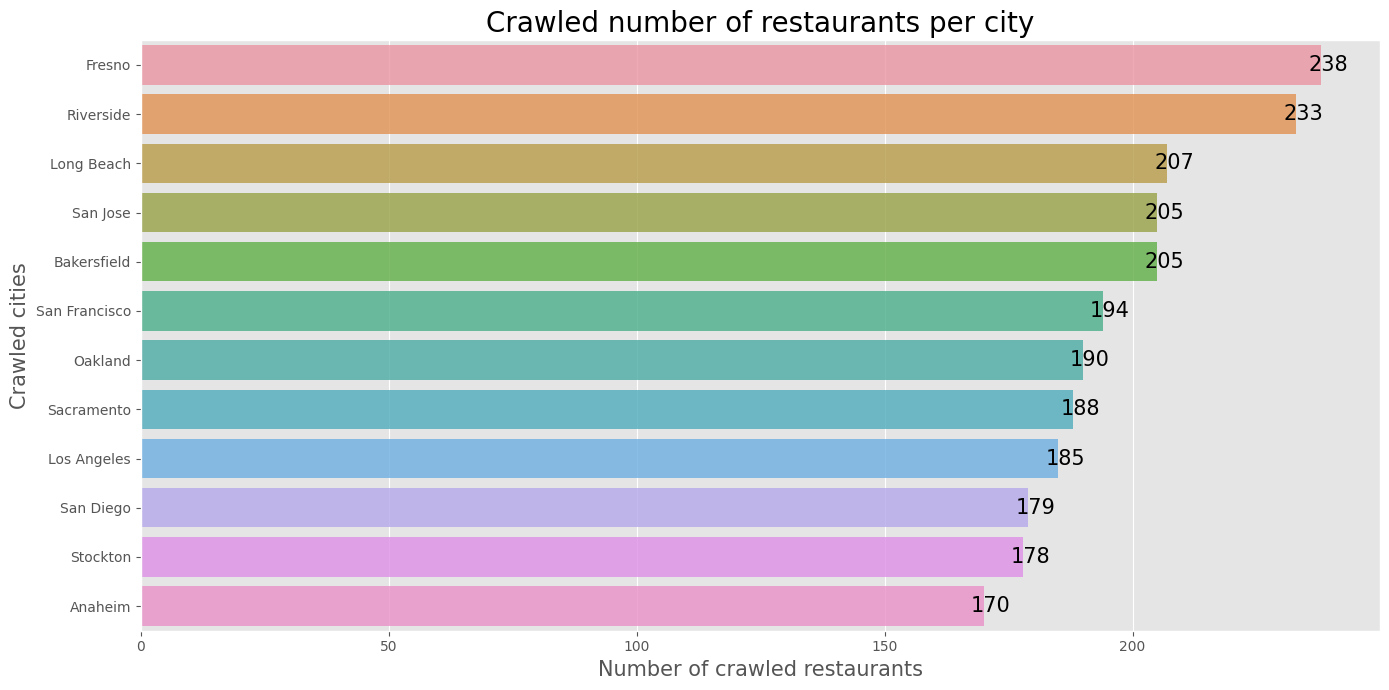

In [7]:
# Extracted sorted total number of restaurants across different cities
Data_of_Cities = cities_list[:12]
DataFrame_data = [LA_data.shape[0], San_Diego_data.shape[0], San_Jose_data.shape[0], San_Fransisco_data.shape[0],
               Fresno_data.shape[0], Sacramento_data.shape[0], Long_Beach_data.shape[0], Oakland_data.shape[0],
               Bakersfield_data.shape[0], Anaheim_data.shape[0], Santa_Ana_data.shape[0], Riverside_data.shape[0]]
comp_dict = {"Cities": Data_of_Cities, "Restaurants_number": DataFrame_data}
comp_df = pd.DataFrame(data=comp_dict).sort_values("Restaurants_number", ascending=False)

# Visualize the number of restaurants per city using matplotlib/sns
plt.figure(figsize=(14, 7))
bar_plot = sns.barplot(data=comp_df, y='Cities', x='Restaurants_number', alpha=0.8)
bar_plot.set_title("Crawled number of restaurants per city", fontsize=20)
bar_plot.set_xlabel("Number of crawled restaurants", fontsize=15)
bar_plot.set_ylabel("Crawled cities", fontsize=15)
for bar in bar_plot.patches:
    bar_plot.annotate(format(bar.get_width(), '.0f'), 
                      (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                      ha='center', va='center',
                      size=15, xytext=(5, 0), 
                      textcoords='offset points')
plt.tight_layout()
# Save the current figure to a directory
plt.savefig('../Images/1_bar_number_of_restaurants_per_city.png')
plt.show()

The number of restaurants in the above figure are not the total number of restaurants in the respective places, but the maximum number of places that Yelp let us scrap. From the figure, we could undertand that the restaurants in Bay Area, LA, etc. are much larger when compared to other cities such as Bakersfield, Long Beach, etc.

In [8]:
Combined_Dataframe = pd.concat([LA_data, San_Diego_data, San_Jose_data, San_Fransisco_data,
                        Fresno_data, Sacramento_data, Long_Beach_data, Oakland_data,
                        Bakersfield_data, Anaheim_data, Santa_Ana_data, Riverside_data]).reset_index(drop=True)

In [9]:
# Remove duplicates and reset index
Combined_Dataframe = Combined_Dataframe.drop_duplicates()
Combined_Dataframe = Combined_Dataframe.reset_index()

In [10]:
exceptions(Combined_Dataframe, verbose=True)
Final_DataFrame_Combined = Combined_Dataframe.applymap(find_null)

No exceptions detected


In [11]:
# Generate final dataframe for further analysis
Final_DataFrame_Combined=Final_DataFrame_Combined.drop(0)
Final_DataFrame_Combined.head()

,index,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,Fri,Sat,Sun
1,1,Jinsol Gukbap 8th,"3428 W 8th St Los Angeles, CA 90005",Korean,$$,(66 reviews),4.8,10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day)
2,2,Cooking Mom,"3660 Wilshire Blvd Ste 120 Los Angeles, CA 90010","Korean, Specialty Food, Soup",$$,(36 reviews),4.8,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,Closed,Closed
3,3,Budonoki,"654 N Virgil Ave Los Angeles, CA 90004","Izakaya, Sushi Bars, Beer Bar",Unknown,(76 reviews),4.6,Closed,Closed,5:30 PM - 10:00 PM,5:30 PM - 10:00 PM,5:30 PM - 10:00 PM,5:30 PM - 10:00 PM,5:30 PM - 10:00 PM
4,4,Langer's Delicatessen,"704 S Alvarado St Los Angeles, CA 90057","Delis, Sandwiches",$$,"(4,520 reviews)",4.4,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,Closed
5,5,Osteria La Buca,"5210 Melrose Ave Los Angeles, CA 90038","Italian, Pizza, Cocktail Bars",$$,"(2,293 reviews)",4.1,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,5:00 PM - 11:00 PM,11:30 AM - 2:30 PM


In [12]:
# Add zip code
Final_DataFrame_Combined['ZIP'] = Final_DataFrame_Combined.Address.apply(get_ZIP)

In [13]:
# Display price categories extracted
Final_DataFrame_Combined.Price.value_counts()

Price
$$         1454
Unknown     453
$$$         144
$           133
$$$$         46
Name: count, dtype: int64

In [14]:
def extract_ratings(rating_str):
    '''
    Function to extract ratings from input text using regular expressions
    '''
    try:
        return int(''.join(re.findall(r'\d+', rating_str)).replace(',', ''))
    except (ValueError, AttributeError):
        return 0

Final_DataFrame_Combined['Rating'] = Final_DataFrame_Combined['Rating'].apply(extract_ratings)
Final_DataFrame_Combined.head()

,index,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,Fri,Sat,Sun,ZIP
1,1,Jinsol Gukbap 8th,"3428 W 8th St Los Angeles, CA 90005",Korean,$$,66,4.8,10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),CA 90005
2,2,Cooking Mom,"3660 Wilshire Blvd Ste 120 Los Angeles, CA 90010","Korean, Specialty Food, Soup",$$,36,4.8,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,Closed,Closed,CA 90010
3,3,Budonoki,"654 N Virgil Ave Los Angeles, CA 90004","Izakaya, Sushi Bars, Beer Bar",Unknown,76,4.6,Closed,Closed,5:30 PM - 10:00 PM,5:30 PM - 10:00 PM,5:30 PM - 10:00 PM,5:30 PM - 10:00 PM,5:30 PM - 10:00 PM,CA 90004
4,4,Langer's Delicatessen,"704 S Alvarado St Los Angeles, CA 90057","Delis, Sandwiches",$$,4520,4.4,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,Closed,CA 90057
5,5,Osteria La Buca,"5210 Melrose Ave Los Angeles, CA 90038","Italian, Pizza, Cocktail Bars",$$,2293,4.1,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,5:00 PM - 11:00 PM,11:30 AM - 2:30 PM,CA 90038


### Section III: Data analysis and visualization

To understand how the distribution of restaurants is in the above selected locations, we look at the following:
- Part I: Restaurants ratings distribution analysis
- Part II: Restaurants categorical analysis
- Part III: Restaurants reviews distribution analysis based on cities
- Part IV: Restaurants geo-spatial analysis
- Part V: Top 25 reviewed restaurants

After this above workflow, we expect to gain strong data insights from graphical methods. 

### Part I: Restaurants ratings distribution analysis 

- 1. Overall ratings distributions.
- 2. Individual cities ratings distributions.

In [15]:
class Distribution_plot:
    '''
    Class comprising commong functions to plot distribution of data using bars
    '''
    def __init__(self, df):
        self.df = df
        
    def plot(self, font_size, title, text_height):
        counts = self.df['Reviews'].value_counts().sort_index()
        ax = sns.barplot(x=counts.index, y=counts.values, alpha=0.8)
        plt.title(title, fontsize=font_size)
        plt.xlabel("Ratings", fontsize=font_size)
        plt.ylabel("# of Restaurants", fontsize=font_size)
        for rect, count in zip(ax.patches, counts.values):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height + text_height, count,
                    ha='center', va='bottom')
    
    def clean_each_city_df(self):
        # Remove null values
        exceptions(self.df)
        clean_df = self.df.applymap(find_null)
        return clean_df

In [16]:
# DataFrame Operations: Manipulate and analyze data using pandas.
Final_DataFrame_Combined

,index,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,Fri,Sat,Sun,ZIP
1,1,Jinsol Gukbap 8th,"3428 W 8th St Los Angeles, CA 90005",Korean,$$,66,4.8,10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),CA 90005
2,2,Cooking Mom,"3660 Wilshire Blvd Ste 120 Los Angeles, CA 90010","Korean, Specialty Food, Soup",$$,36,4.8,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,Closed,Closed,CA 90010
3,3,Budonoki,"654 N Virgil Ave Los Angeles, CA 90004","Izakaya, Sushi Bars, Beer Bar",Unknown,76,4.6,Closed,Closed,5:30 PM - 10:00 PM,5:30 PM - 10:00 PM,5:30 PM - 10:00 PM,5:30 PM - 10:00 PM,5:30 PM - 10:00 PM,CA 90004
4,4,Langer's Delicatessen,"704 S Alvarado St Los Angeles, CA 90057","Delis, Sandwiches",$$,4520,4.4,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,Closed,CA 90057
5,5,Osteria La Buca,"5210 Melrose Ave Los Angeles, CA 90038","Italian, Pizza, Cocktail Bars",$$,2293,4.1,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,5:00 PM - 11:00 PM,11:30 AM - 2:30 PM,CA 90038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226,2366,Fish Taco Xtreme,"16960 Van Buren Blvd Ste D Riverside, CA 92504","Mexican, Seafood",Unknown,87,4.3,9:00 AM - 8:00 PM,9:00 AM - 8:00 PM,9:00 AM - 8:00 PM,9:00 AM - 8:00 PM,9:00 AM - 8:00 PM,9:00 AM - 7:00 PM,9:00 AM - 7:00 PM,CA 92504
2227,2367,Pho 81 Vietnamese Cuisine,"2995 Van Buren Blvd Ste A13 Riverside, CA 92503",Vietnamese,$$,172,4.7,Closed,9:30 AM - 9:00 PM,9:30 AM - 9:00 PM,9:30 AM - 9:00 PM,9:30 AM - 9:00 PM,9:30 AM - 9:00 PM,9:30 AM - 9:00 PM,CA 92503
2228,2368,European Deli Market,"7120 Indiana Ave Ste G Riverside, CA 92504","Grocery, Delis, Meat Shops",$$,113,4.2,10:00 AM - 6:00 PM,10:00 AM - 6:00 PM,10:00 AM - 6:00 PM,10:00 AM - 6:00 PM,10:00 AM - 6:00 PM,10:00 AM - 6:00 PM,Closed,CA 92504
2229,2369,La Familia Street Tacos & More,"10759 Magnolia Ave Riverside, CA 92505",Tacos,Unknown,36,4.8,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,CA 92505


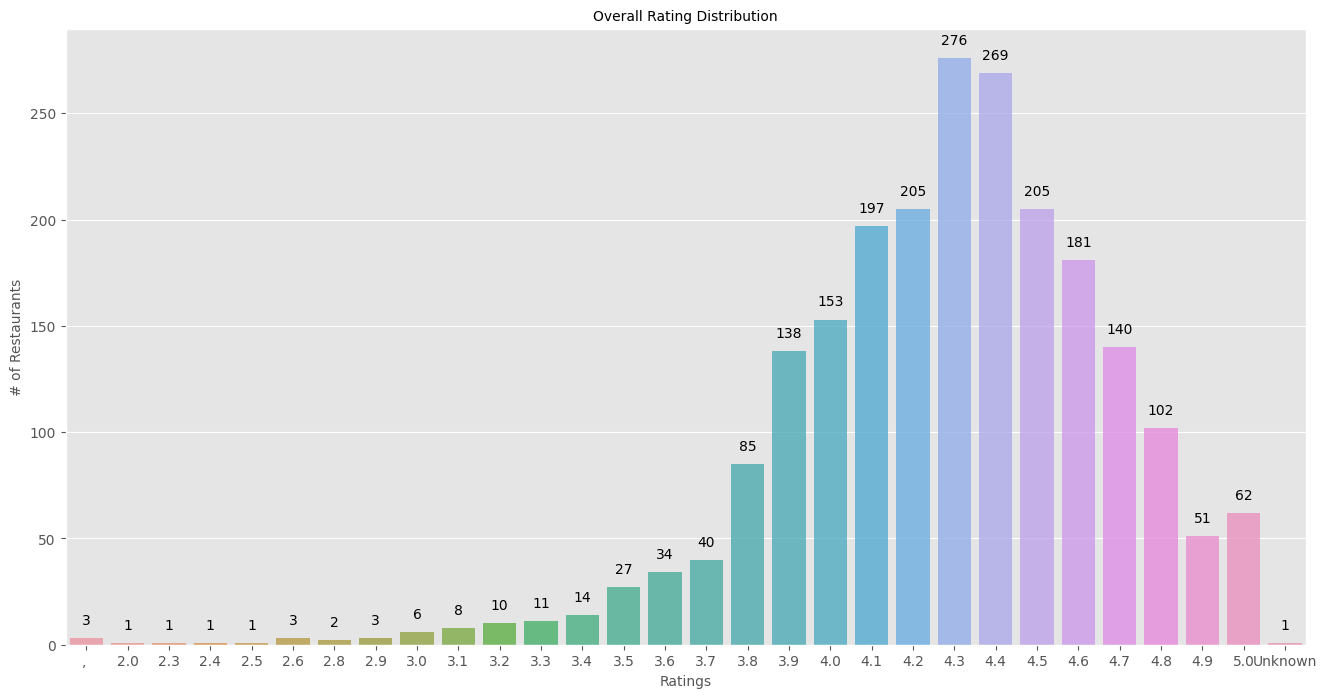

In [17]:
# Plot distribution of overall restaurant ratings
plt.figure(figsize=(16, 8))
ratdist = Distribution_plot(Final_DataFrame_Combined)
ratdist.plot(font_size=10,title="Overall Rating Distribution",text_height=5)
plt.savefig('../Images/2_bar_overall_rating_distribution.png')

**Observation and comments:**

From the above plot:
- 1.The overall restaurants ratings distribution was **left skewed**, which means majority of restaurants have ratings between 3.5 to 5.0. 

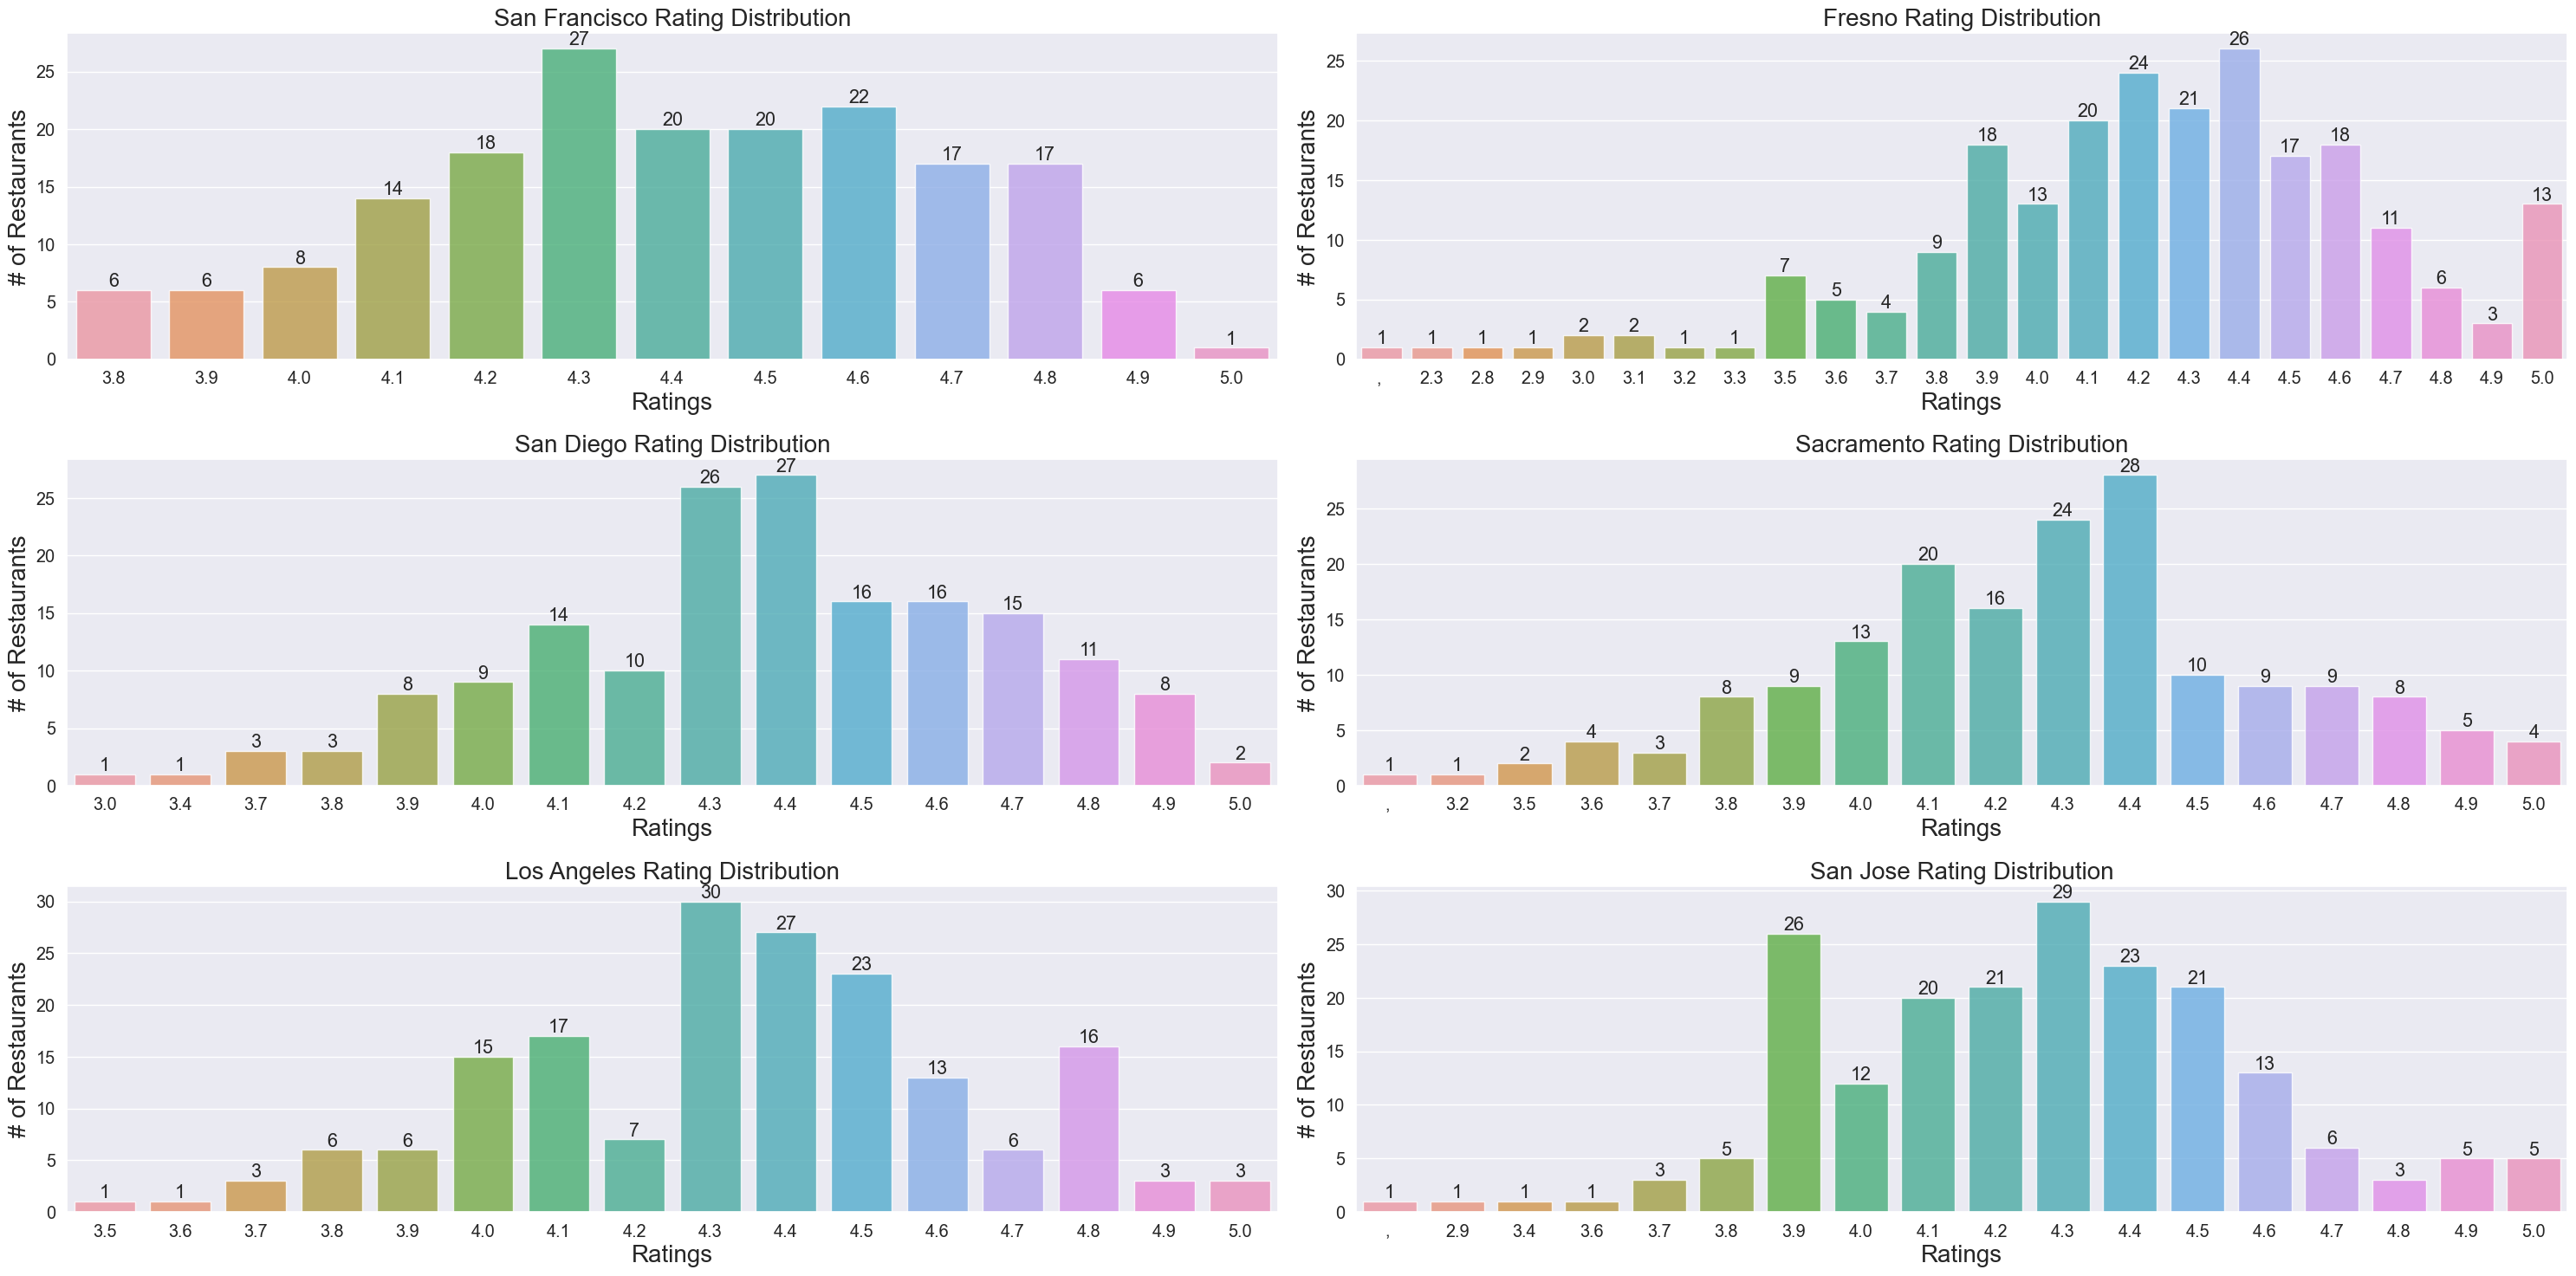

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize': (30, 15)})
sns.set(font_scale=1.3)
plt.subplots(3, 2, figsize=(30, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
city_data_dict = {
    "San Francisco": San_Fransisco_data,
    "Fresno": Fresno_data,
    "San Diego": San_Diego_data,
    "Sacramento": Sacramento_data,
    "Los Angeles": LA_data,
    "San Jose": San_Jose_data,
}
jumbled_cities_order = [
    "San Francisco",
    "Fresno",
    "San Diego",
    "Sacramento",
    "Los Angeles",
    "San Jose",
]

# Generate rating distributions for different cities in our dataset
for index, city_name in enumerate(jumbled_cities_order):
    plt.subplot(3, 2, index + 1)
    current_city_data = city_data_dict[city_name]
    ratdist = Distribution_plot(current_city_data)
    clean_city_data = ratdist.clean_each_city_df()
    ratdist.plot(20, f"{city_name} Rating Distribution", text_height=0)

plt.tight_layout()
plt.savefig('../Images/3_bars_rating_distribution_by_city_1.png')
plt.show()

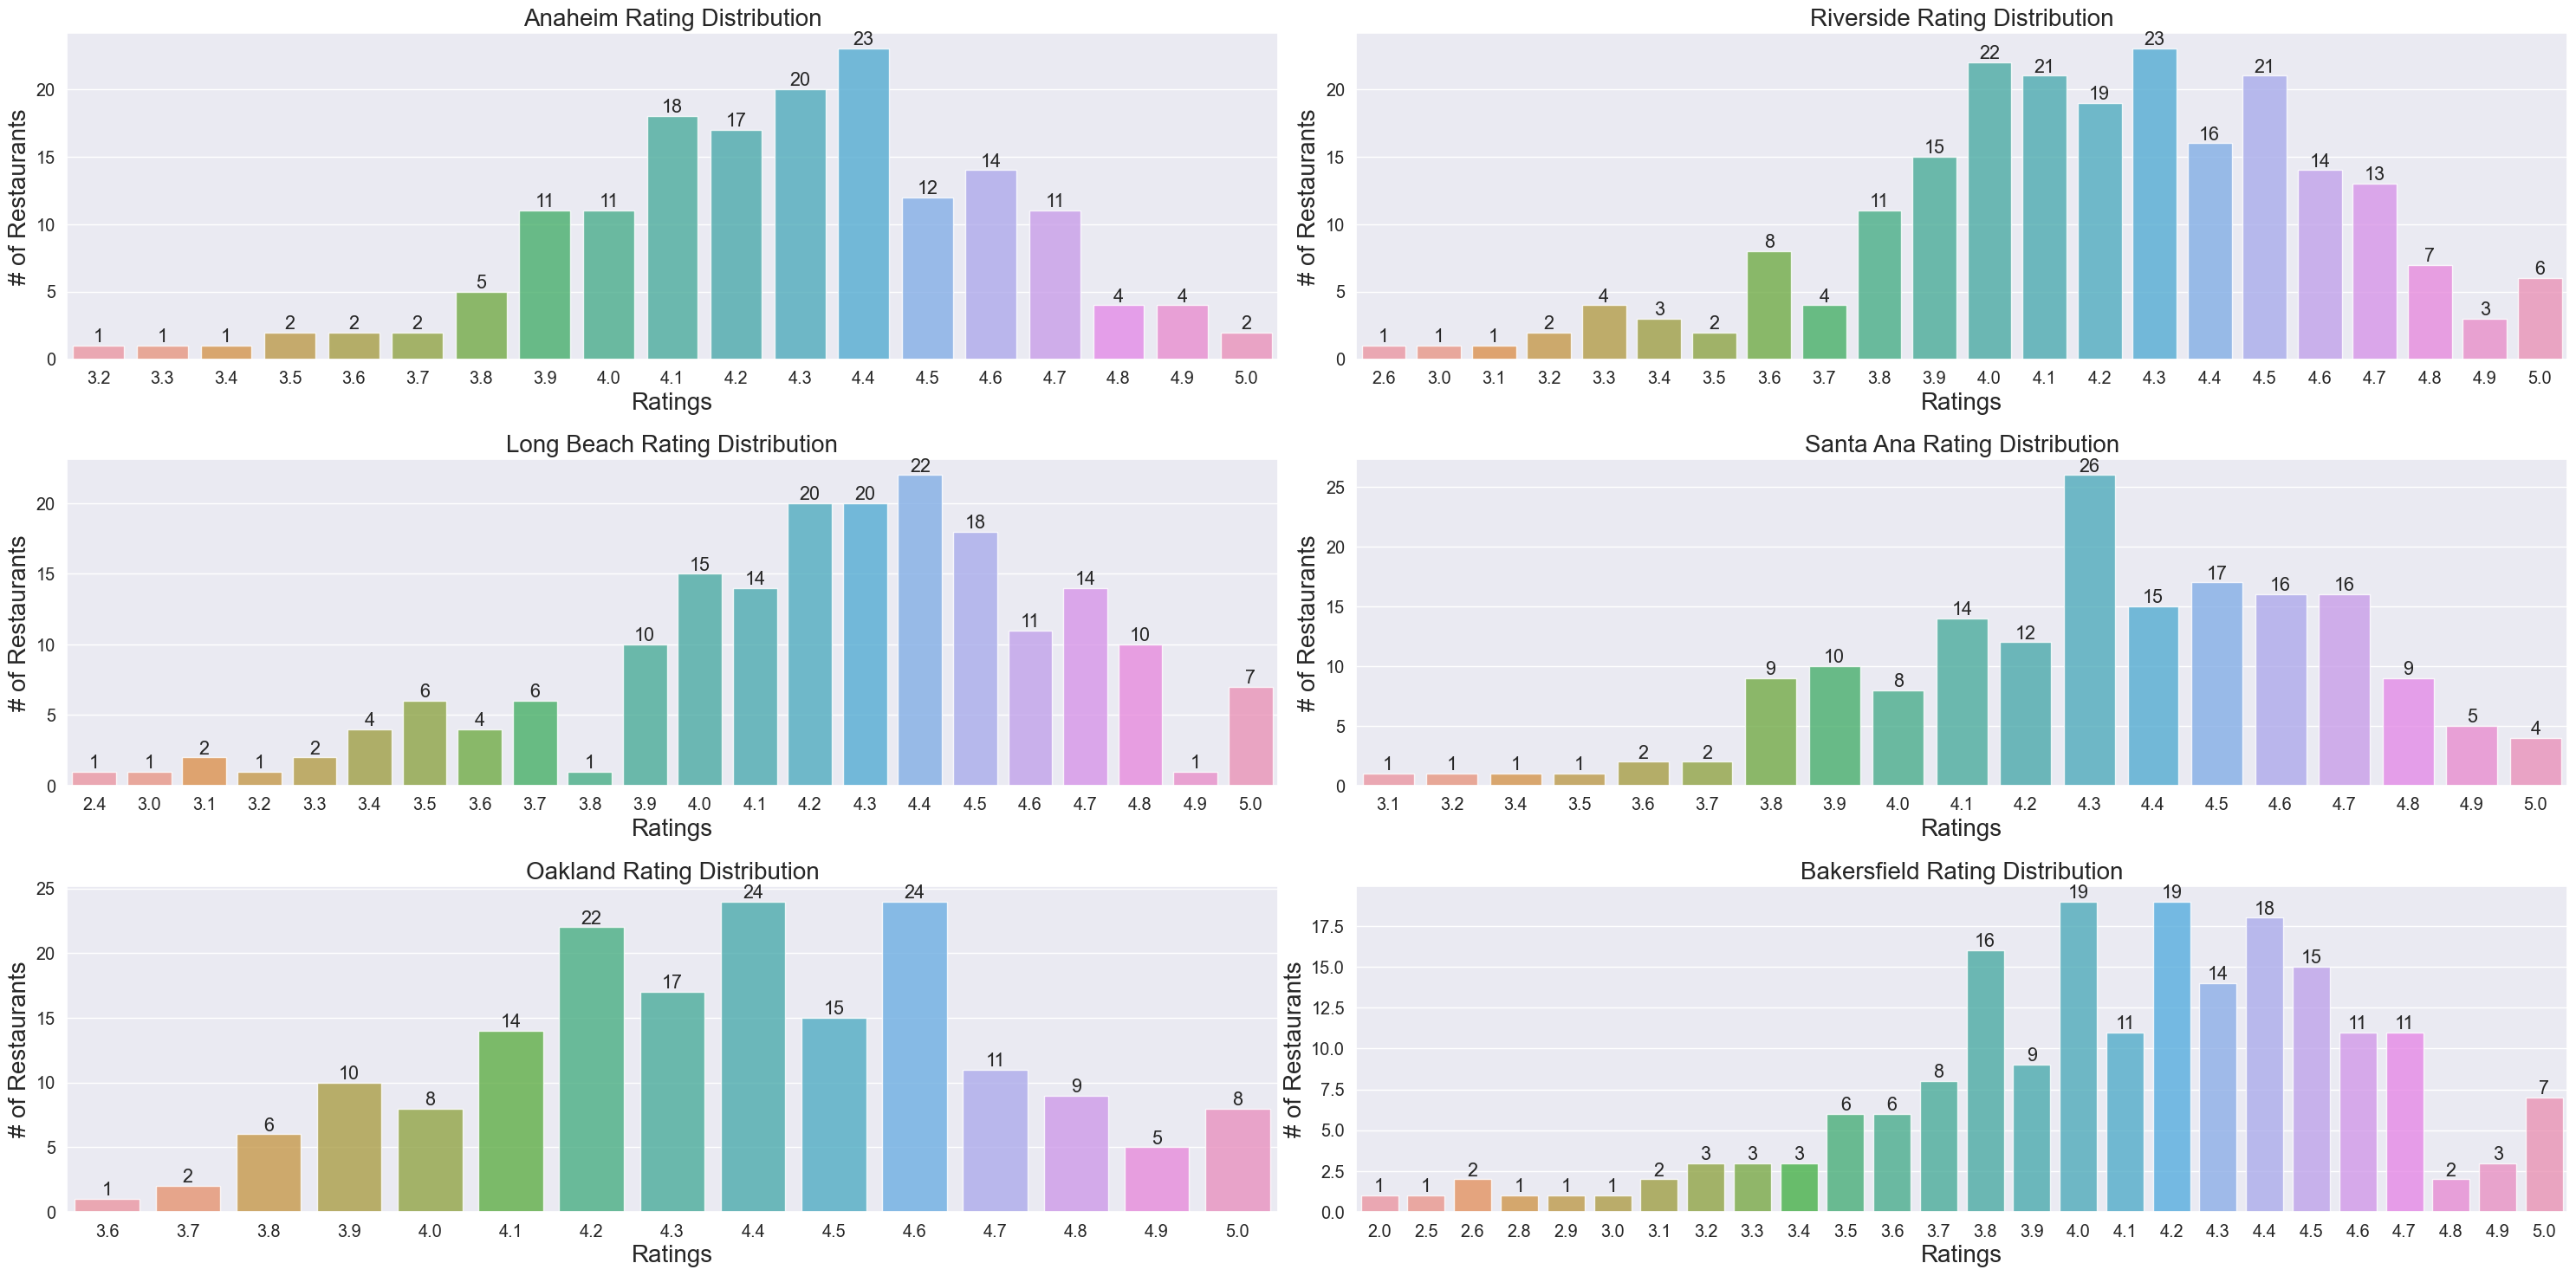

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize': (30, 15)})
sns.set(font_scale=1.3)

plt.subplots(3, 2, figsize=(30, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.7)
city_plot_data = {
    "Long Beach": Long_Beach_data,
    "Oakland": Oakland_data,
    "Bakersfield": Bakersfield_data,
    "Anaheim": Anaheim_data,
    "Santa Ana": Santa_Ana_data,
    "Riverside": Riverside_data,
}
city_order = [
    "Anaheim",
    "Riverside",
    "Long Beach",
    "Santa Ana",
    "Oakland",
    "Bakersfield",
]

# Generate rating distributions for the remaining cities in our dataset
for index, city_name in enumerate(city_order):
    plt.subplot(3, 2, index + 1)
    current_city_data = city_plot_data[city_name]
    ratdist = Distribution_plot(current_city_data)
    clean_city_data = ratdist.clean_each_city_df()
    ratdist.plot(20, f"{city_name} Rating Distribution", text_height=0)

plt.tight_layout()
plt.savefig('../Images/4_bar_number_of_restaurants_per_city_2.png')
plt.show()

**Observation and comments:**

From the above plot:
- 1. Generally, Los Angeles, San Diego, San Francisco, Oakland have lowest portion of restaurants with rating below 4.0.
- 2. Fresno, Bakersfield, and Riverside have more frequency of low ratings restaurants compared with other cities. 
- 3. Majority of ratings are 3.5 to 4.5, we saw the geneous of Yelp reviewers on these restaurants.
- 4. Bakersfield and Riverside had relatively uniform rating distributions.

### Part II: Restaurants categorical analysis 


In [20]:
import pandas as pd
import re
import numpy as np
import os
import nltk
import string
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 
from collections import defaultdict
from nltk.corpus import stopwords
from Feature_Engineering import *
nltk.download('stopwords')


class CategoryFrequencyPlotter:
    '''
    Class with necessary functionalities to generate different plots
    '''
    def __init__(self, dataframe, punctuation_to_remove=string.punctuation):
        self.regex_pattern = fr"[{punctuation_to_remove}]"
        self.frequency_dict = {}
        self.df = dataframe
        self.category_ratings = defaultdict(list)
        self.category_avg_ratings = {}
        self.category_reviews = defaultdict(int)
        
    def _split_clean_join(self, text):
        '''
        Function to preprocess the data
        '''
        try:
            split_text = re.split(self.regex_pattern, text.strip())
        except:
            raise Exception(f'Error: The text "{text}" is not a string')
        for word in split_text:
            cleaned_word = word.strip()
            if cleaned_word in self.frequency_dict:
                self.frequency_dict[cleaned_word] += 1
            else:
                self.frequency_dict[cleaned_word] = 0 if cleaned_word == '' else 1
        return " ".join(split_text)
    
    def count_categories(self):
        '''
        Function to count occurrences of each category
        '''
        self.df[['Category']].applymap(self._split_clean_join)  
        self.frequency_dict.pop('Unknown', None) 
        self.frequency_dict.pop('', None)  
        return self.frequency_dict
    
    def plot_category_frequencies(self, top_n, title_font_size, chart_title, include_overall=False, show_details=False):
        '''
        Function to generate plot
        '''
        cat_freq_dataframe = pd.DataFrame(list(self.frequency_dict.items()), columns=['Category', 'Count']).sort_values('Count', ascending=False)
        total_categories = cat_freq_dataframe.Category.nunique()
        if show_details:
            print(f"Total {total_categories} unique word categories found in Yelp restaurant descriptions")

        top_categories = cat_freq_dataframe.head(top_n)
        if include_overall:
            plt.figure(figsize=(20, 14))
        sns.barplot(x='Count', y='Category', data=top_categories, alpha=0.8)
        plt.title(chart_title, fontsize=title_font_size)
        plt.xlabel('Frequency', fontsize=title_font_size)
        plt.ylabel('Categories', fontsize=title_font_size)

        ax = plt.gca()
        for patch in ax.patches:
            ax.text(patch.get_x() + patch.get_width() + 0.1, patch.get_y() + patch.get_height() / 2, patch.get_width(), ha='left')

    def calculate_average_ratings(self):
        '''
        Function to calculate average ratings
        '''
        for _, row in self.df.iterrows():
            categories = row['Category'].split(',')
            try:
                rating = float(row['Reviews'])
            except:
                continue
            for category in categories:
                self.category_ratings[category.strip()].append(rating)
        self.category_avg_ratings = {category: sum(ratings)/len(ratings) for category, ratings in self.category_ratings.items()}

    def calculate_total_reviews(self):
        '''
        Function to get total number of reviews
        '''
        for _, row in self.df.iterrows():
            categories = row['Category'].split(',')
            try:
                no_rating = int(row['Rating'])
            except:
                continue
            for category in categories:
                category = category.strip()
                self.category_reviews[category] += no_rating
            # print(self.category_reviews)
        # self.category_ratings = {category: sum(ratings) for category, ratings in self.category_ratings.items()}
    
    def plot_total_reviews(self, top_n, title_font_size, chart_title):
        '''
        Function to plot total number of reviews for different restaurants
        '''
        self.calculate_total_reviews()
        cat_avg_rating_df = pd.DataFrame(list(self.category_reviews.items()), columns=['Category', 'Total Reviews']).sort_values('Total Reviews', ascending=False)
        # plt.figure(figsize=(5, 4))
        top_categories = cat_avg_rating_df.head(top_n)
        sns.barplot(x='Total Reviews', y='Category', data=top_categories, alpha=0.8)
        plt.title(chart_title, fontsize=title_font_size)
        plt.xlabel('Total Reviews', fontsize=title_font_size)
        plt.ylabel('Category', fontsize=title_font_size)
        plt.tight_layout()

    def plot_average_ratings(self, top_n, title_font_size, chart_title):
        '''
        Function to plot average rating
        '''
        self.calculate_average_ratings()
        cat_avg_rating_df = pd.DataFrame(list(self.category_avg_ratings.items()), columns=['Category', 'Average Rating']).sort_values('Average Rating', ascending=False)
        # plt.figure(figsize=(5, 4))
        top_categories = cat_avg_rating_df.head(top_n)
        sns.barplot(x='Average Rating', y='Category', data=top_categories, alpha=0.8)
        plt.title(chart_title, fontsize=title_font_size)
        plt.xlabel('Average Rating', fontsize=title_font_size)
        plt.ylabel('Category', fontsize=title_font_size)
        plt.tight_layout()
    
    def generate_wordcloud(self, max_words=30):
        '''
        Function to generate word cloud of given text
        '''
        wordcloud_gen = WordCloud(
            background_color='white',
            stopwords=set(stopwords.words("english")),
            scale=10,
            max_words=max_words,
            max_font_size=40
        ).generate_from_frequencies(frequencies=self.frequency_dict)
        
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(wordcloud_gen, interpolation="bilinear")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yvekaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total 226 unique word categories found in Yelp restaurant descriptions


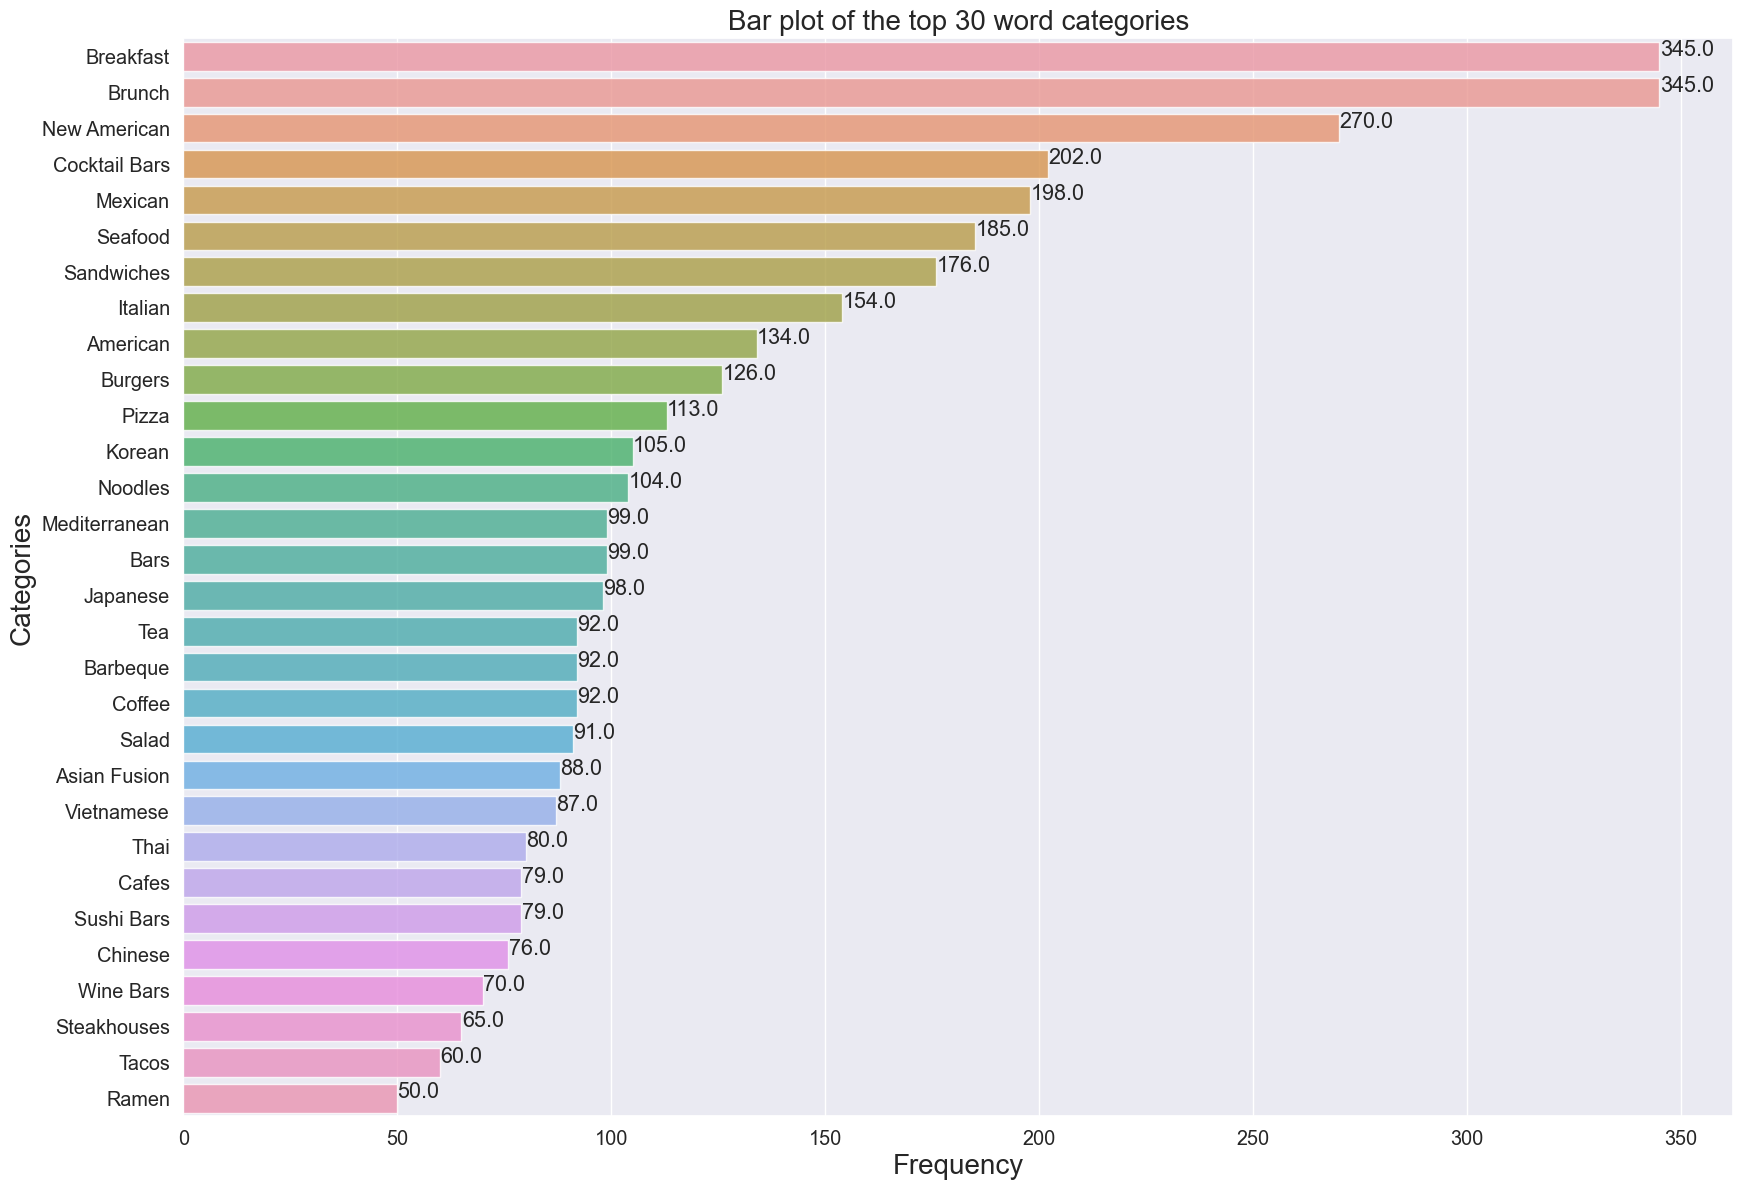

In [21]:
# Plotting distribution of top word categories
sns.set(rc={'figure.figsize':(25,25)})
sns.set(font_scale=1.3)
Frequecy_of_categories = CategoryFrequencyPlotter(Final_DataFrame_Combined)
Frequecy_of_categories.count_categories()
Frequecy_of_categories.plot_category_frequencies(30, 20, "Bar plot of the top 30 word categories", include_overall=True, show_details=True)
plt.savefig('../Images/5_bar_top_30_overall_word_categories.png')

The visualization gave us an insight that quick snack places, such as brunch, breakfast, cocktail bars are some of the categories of restaurants that are most frequent in the full data of restaurants collected.

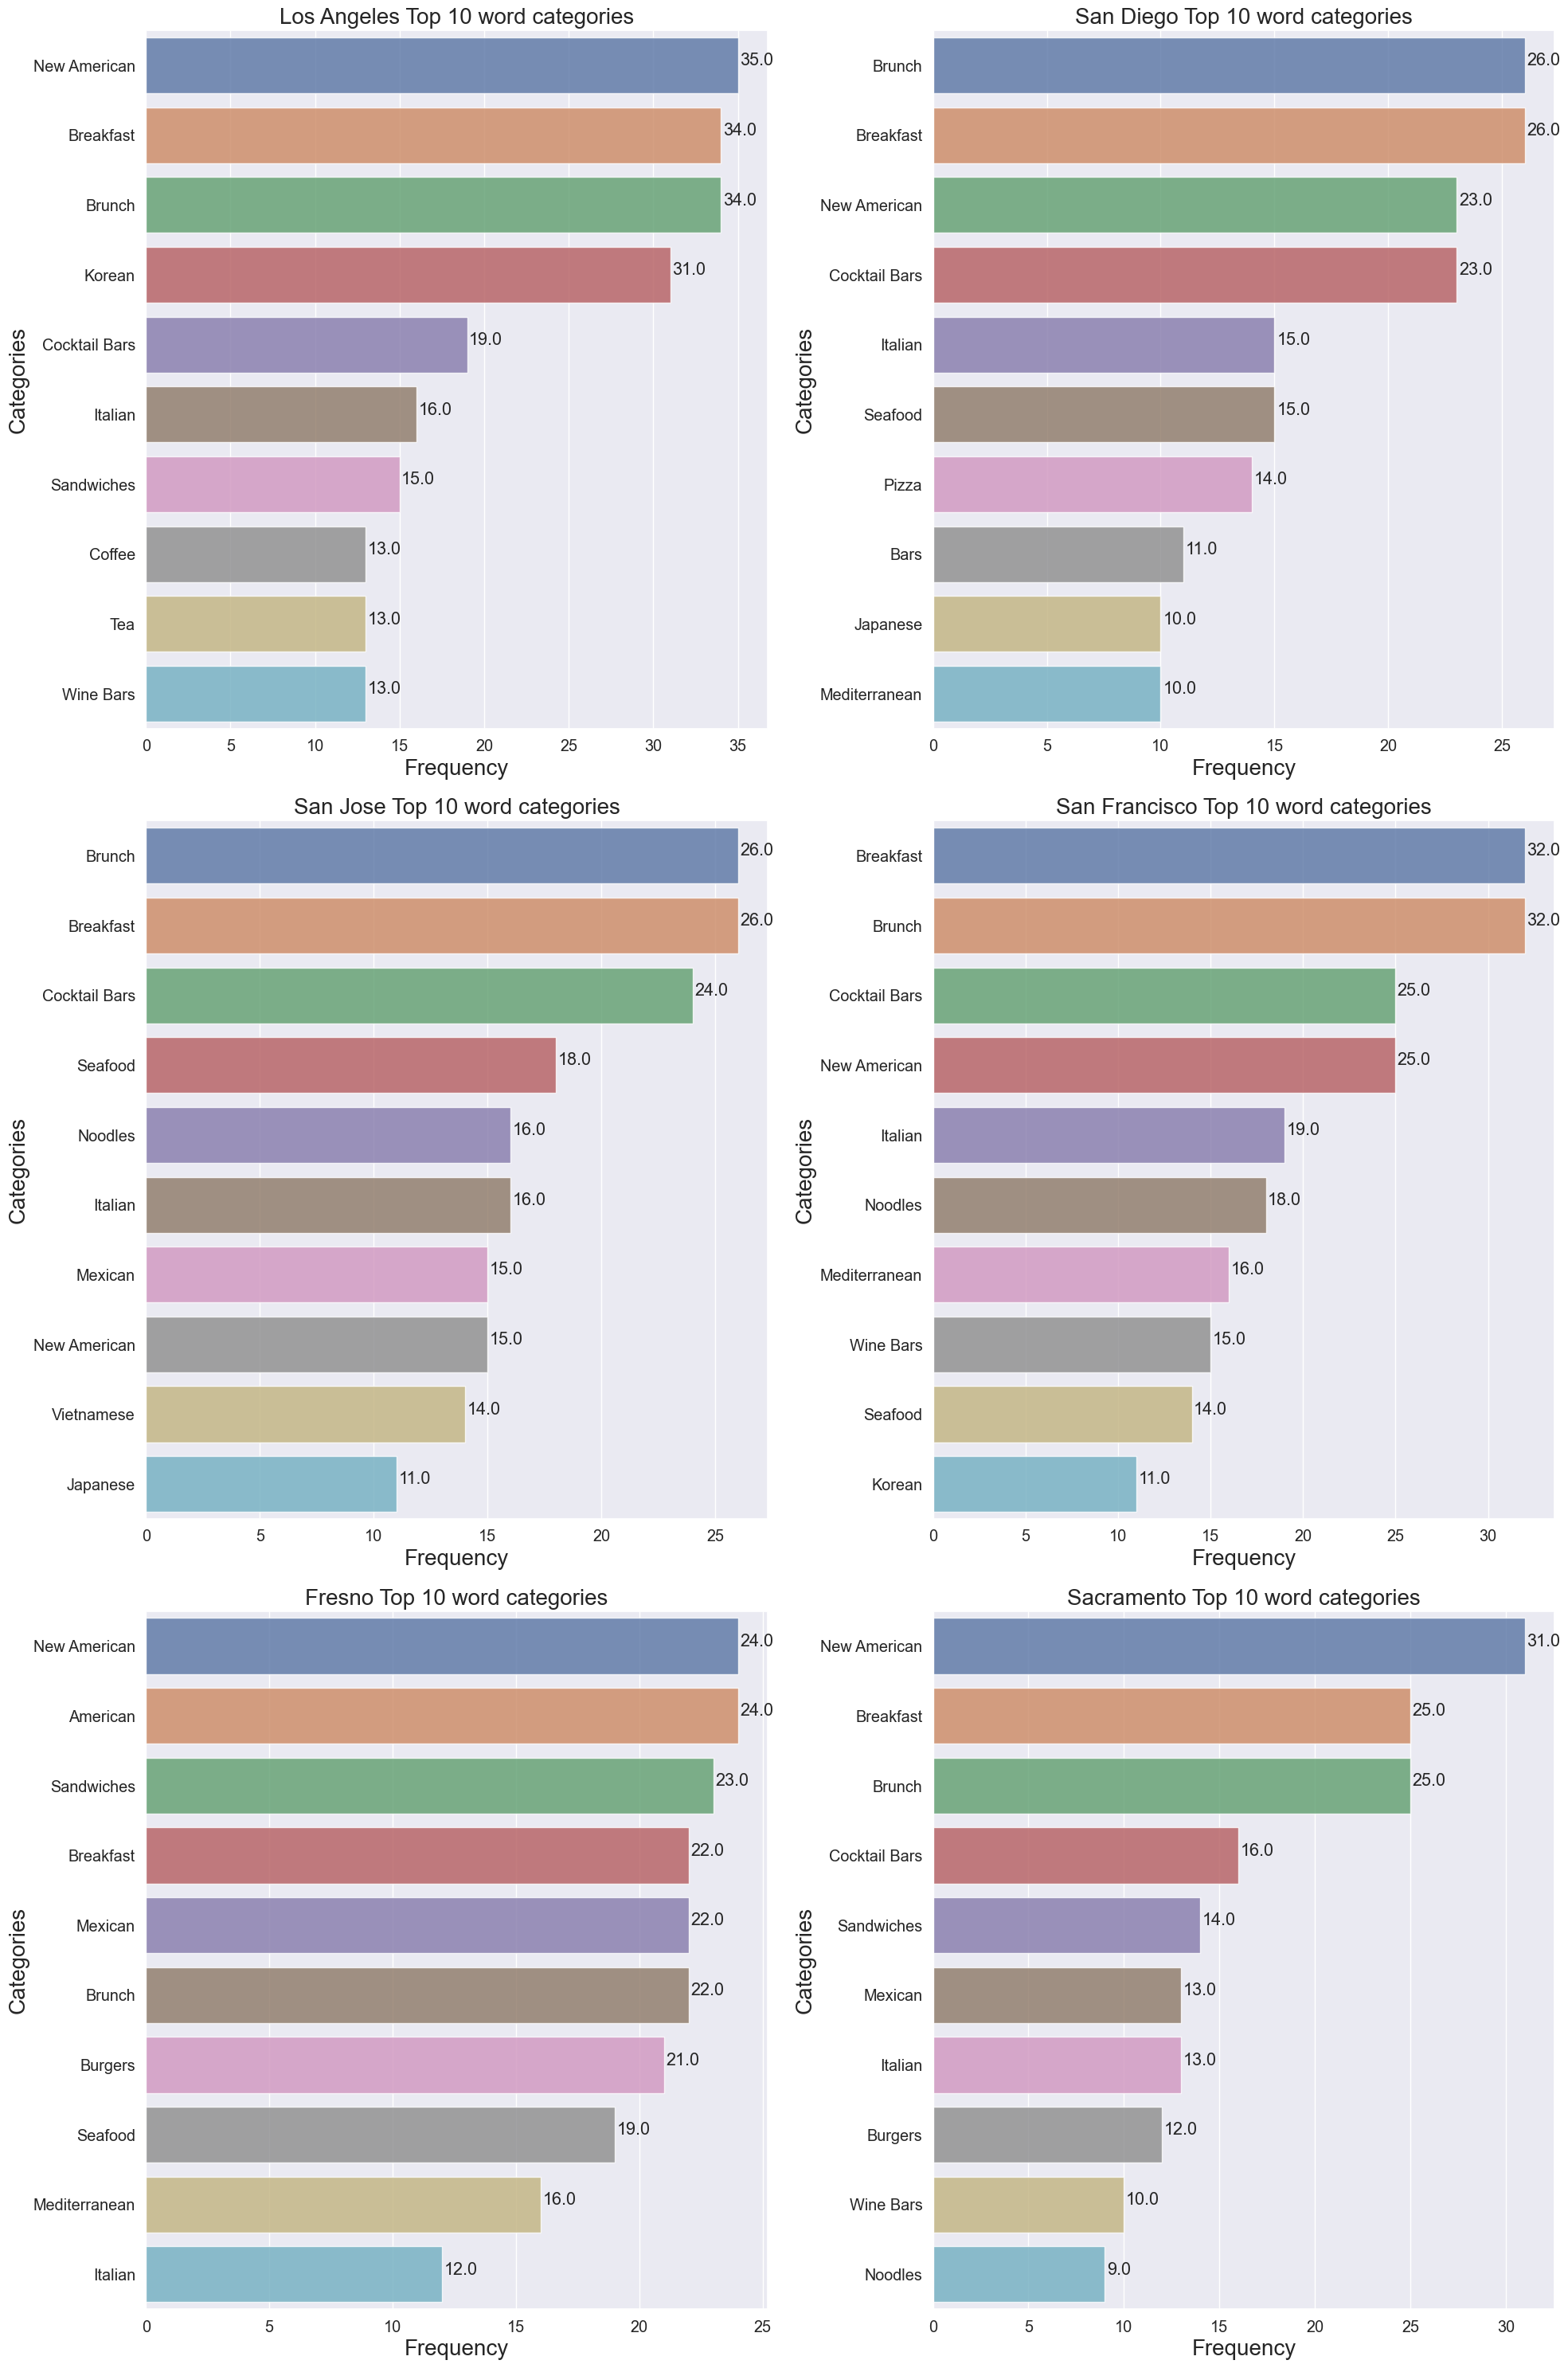

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

# Apply preprocessing to sub dataframes
obj = Distribution_plot(LA_data)
LA_data_clean=obj.clean_each_city_df()

obj = Distribution_plot(San_Diego_data)
San_Diego_data_clean=obj.clean_each_city_df()

obj = Distribution_plot(San_Jose_data)
San_Jose_data_clean=obj.clean_each_city_df()

obj = Distribution_plot(San_Fransisco_data)
San_Fransisco_data_clean=obj.clean_each_city_df()

obj = Distribution_plot(Fresno_data)
Fresno_data_clean=obj.clean_each_city_df()

obj = Distribution_plot(Sacramento_data)
Sacramento_data_clean=obj.clean_each_city_df()

cities_data = {
    "Los Angeles": LA_data_clean,
    "San Diego": San_Diego_data_clean,
    "San Jose": San_Jose_data_clean,
    "San Francisco": San_Fransisco_data_clean,
    "Fresno": Fresno_data_clean,
    "Sacramento": Sacramento_data_clean,
}

# Plot distributions of top 10 word categories for different cities
plt.figure(figsize=(20, 30)) 
for index, (city_name, city_data) in enumerate(cities_data.items(), start=1):
    plt.subplot(3, 2, index)
    Frequecy_of_categoriester = CategoryFrequencyPlotter(city_data)
    Frequecy_of_categoriester.count_categories()
    Frequecy_of_categoriester.plot_category_frequencies(10, 20, f"{city_name} Top 10 word categories")

plt.tight_layout()
plt.savefig('../Images/6_bar_top_10_word_categories_by_city_1.png')
plt.show()


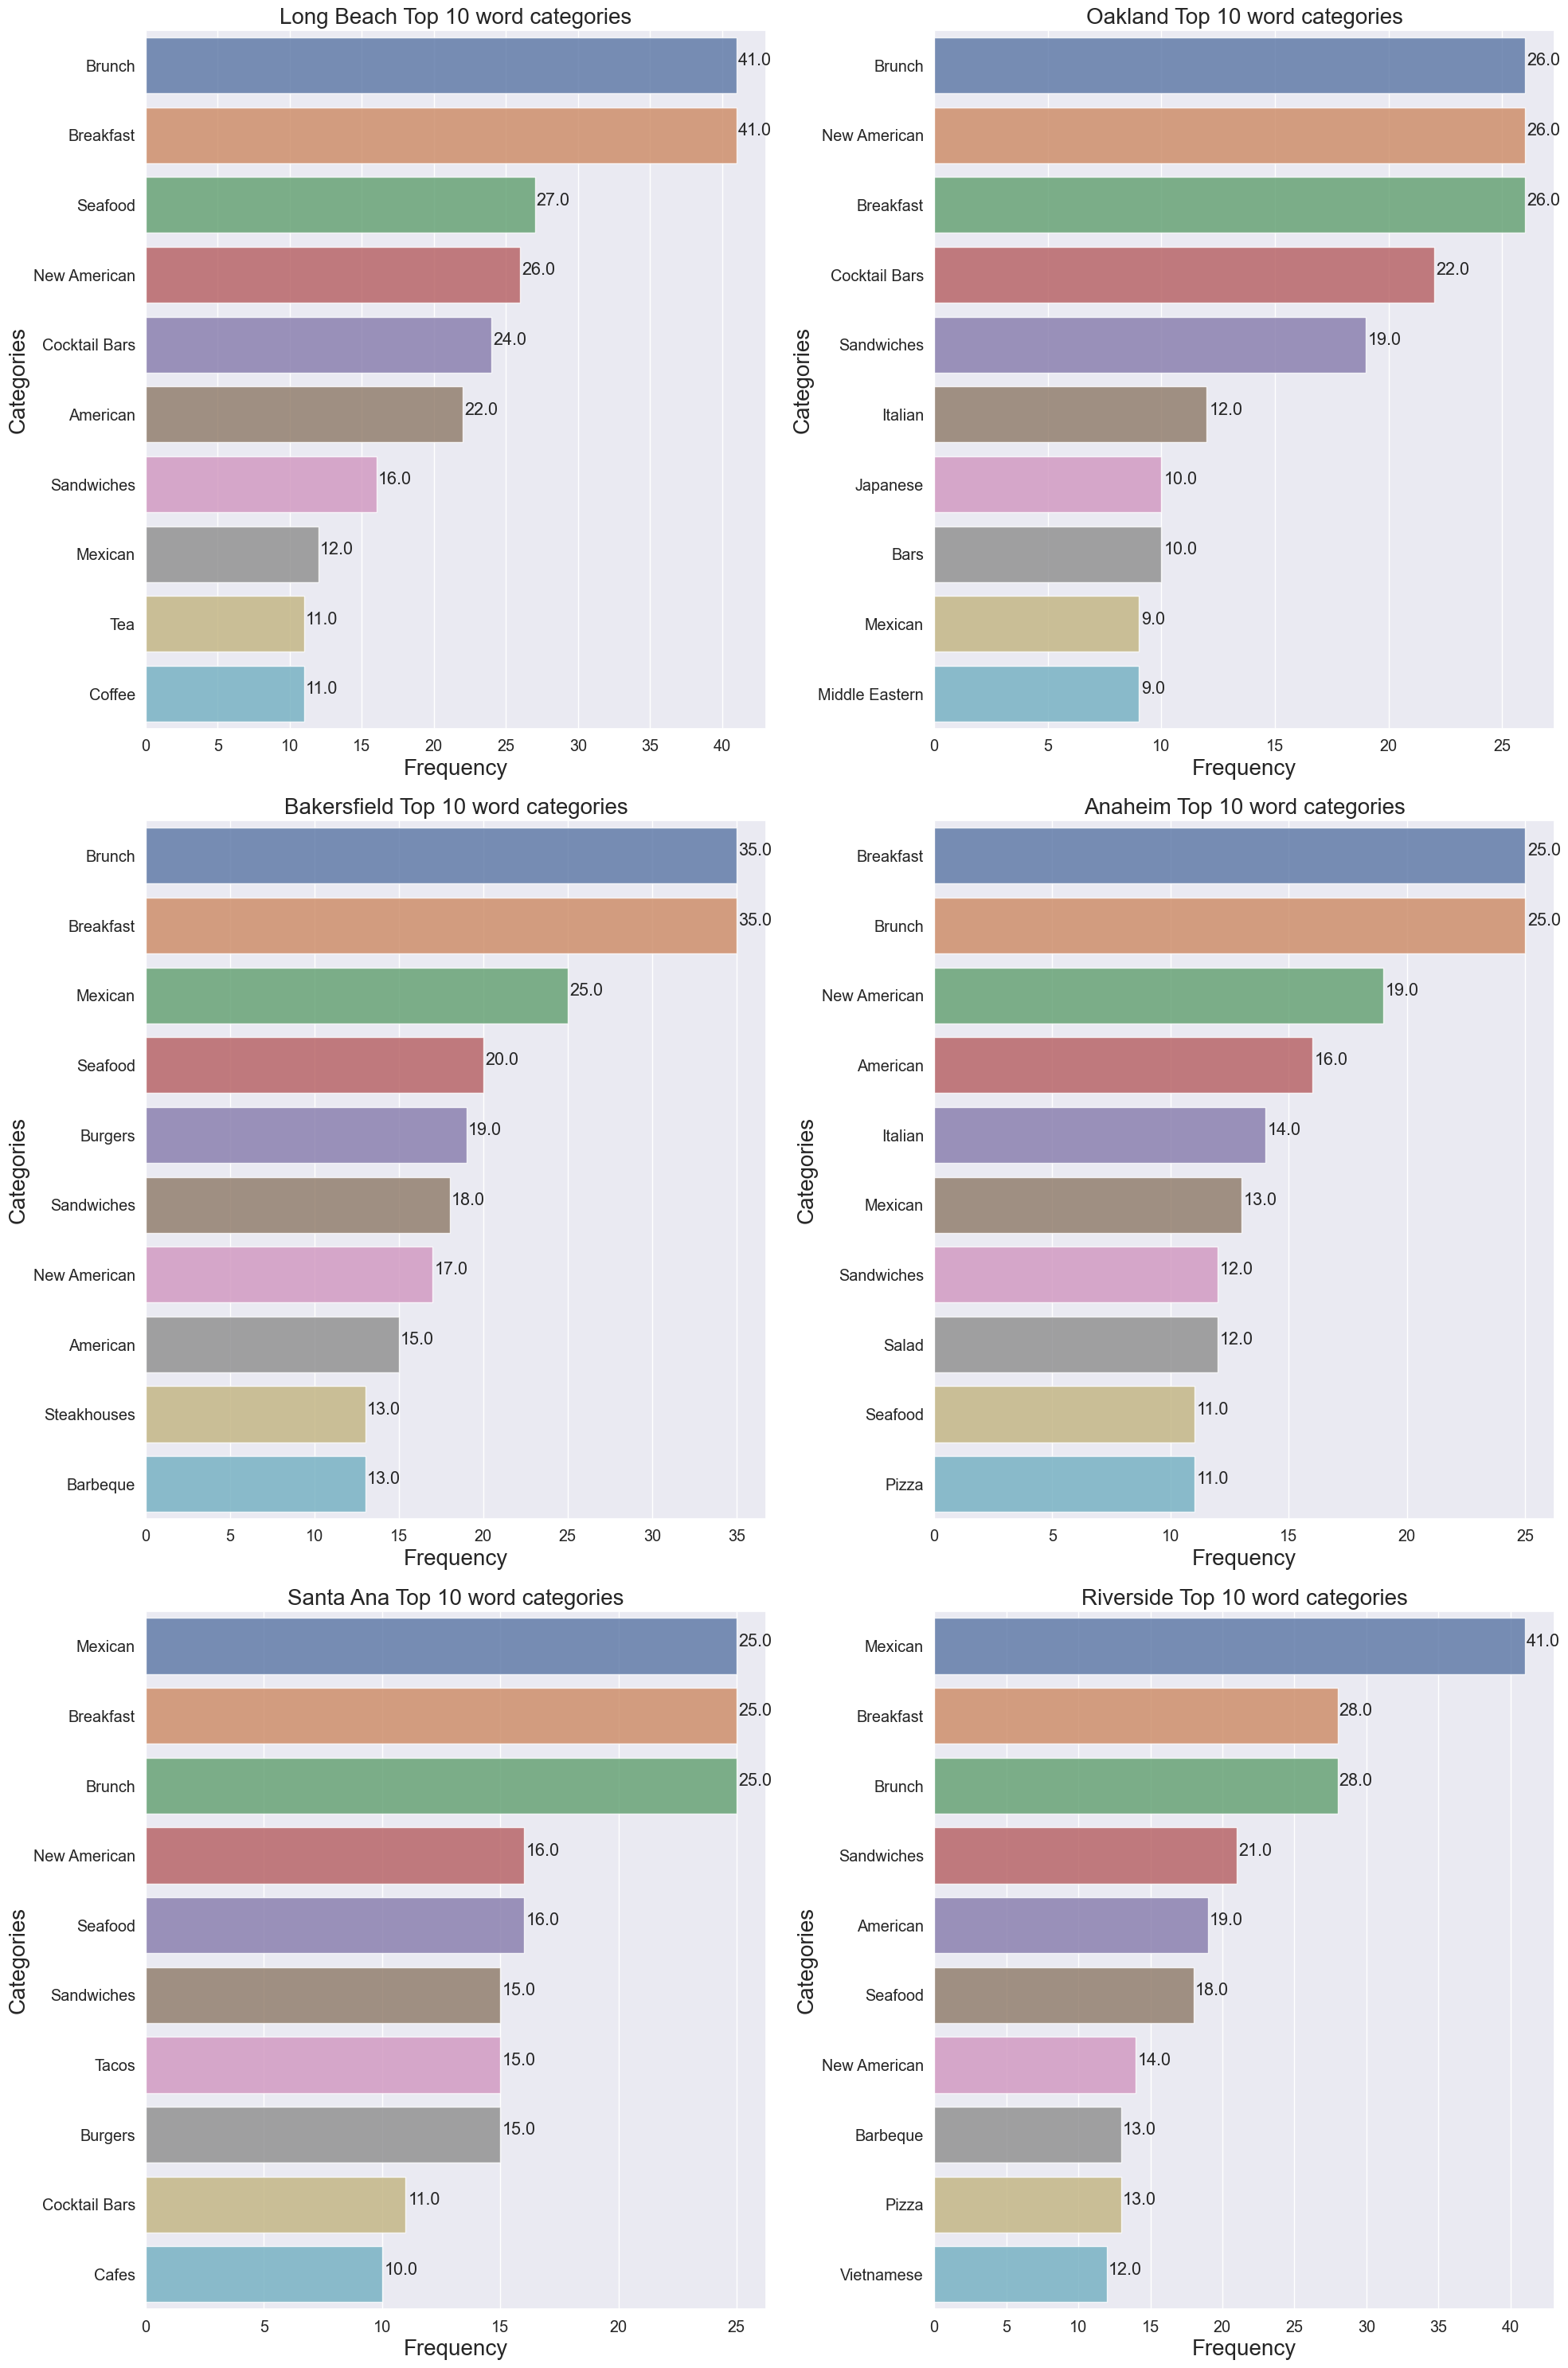

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

# Apply preprocessing to sub dataframes
obj = Distribution_plot(Long_Beach_data)
Long_Beach_data_clean=obj.clean_each_city_df()

obj = Distribution_plot(Oakland_data)
Oakland_data_clean=obj.clean_each_city_df()

obj = Distribution_plot(Bakersfield_data)
Bakersfield_data_clean=obj.clean_each_city_df()

obj = Distribution_plot(Anaheim_data)
Anaheim_data_clean=obj.clean_each_city_df()

obj = Distribution_plot(Santa_Ana_data)
Santa_Ana_data_clean=obj.clean_each_city_df()

obj = Distribution_plot(Riverside_data)
Riverside_data_clean=obj.clean_each_city_df()

cities_data = {
    "Long Beach": Long_Beach_data_clean,
    "Oakland": Oakland_data_clean,
    "Bakersfield": Bakersfield_data_clean,
    "Anaheim": Anaheim_data_clean,
    "Santa Ana": Santa_Ana_data_clean,
    "Riverside": Riverside_data_clean,
}

# Plot distributions of top 10 word categories for different cities
plt.figure(figsize=(20, 30)) 
for index, (city_name, city_data) in enumerate(cities_data.items(), start=1):
    plt.subplot(3, 2, index)
    Frequecy_of_categoriester = CategoryFrequencyPlotter(city_data)
    Frequecy_of_categoriester.count_categories()
    Frequecy_of_categoriester.plot_category_frequencies(10, 20, f"{city_name} Top 10 word categories")

plt.tight_layout()
plt.savefig('../Images/7_bar_top_10_word_categories_by_city_2.png')
plt.show()

The thing we noted from analysing all the restaurant's catogory words in each particular city, we observed that breakfast and brunch places are the most frequent restaurant types in maximum of them. On top of that, These two are on top especially in the Bay Area, maybe it is because of hectic schedule people, and they might prefer having a breakfast outside of the house for ease. For instance, Brunch and Breakfast are the highest category in San Jose, San Diego, etc. whereas it is not the case in cities like Fresno.

### Ratings w.r.t to Word Categories

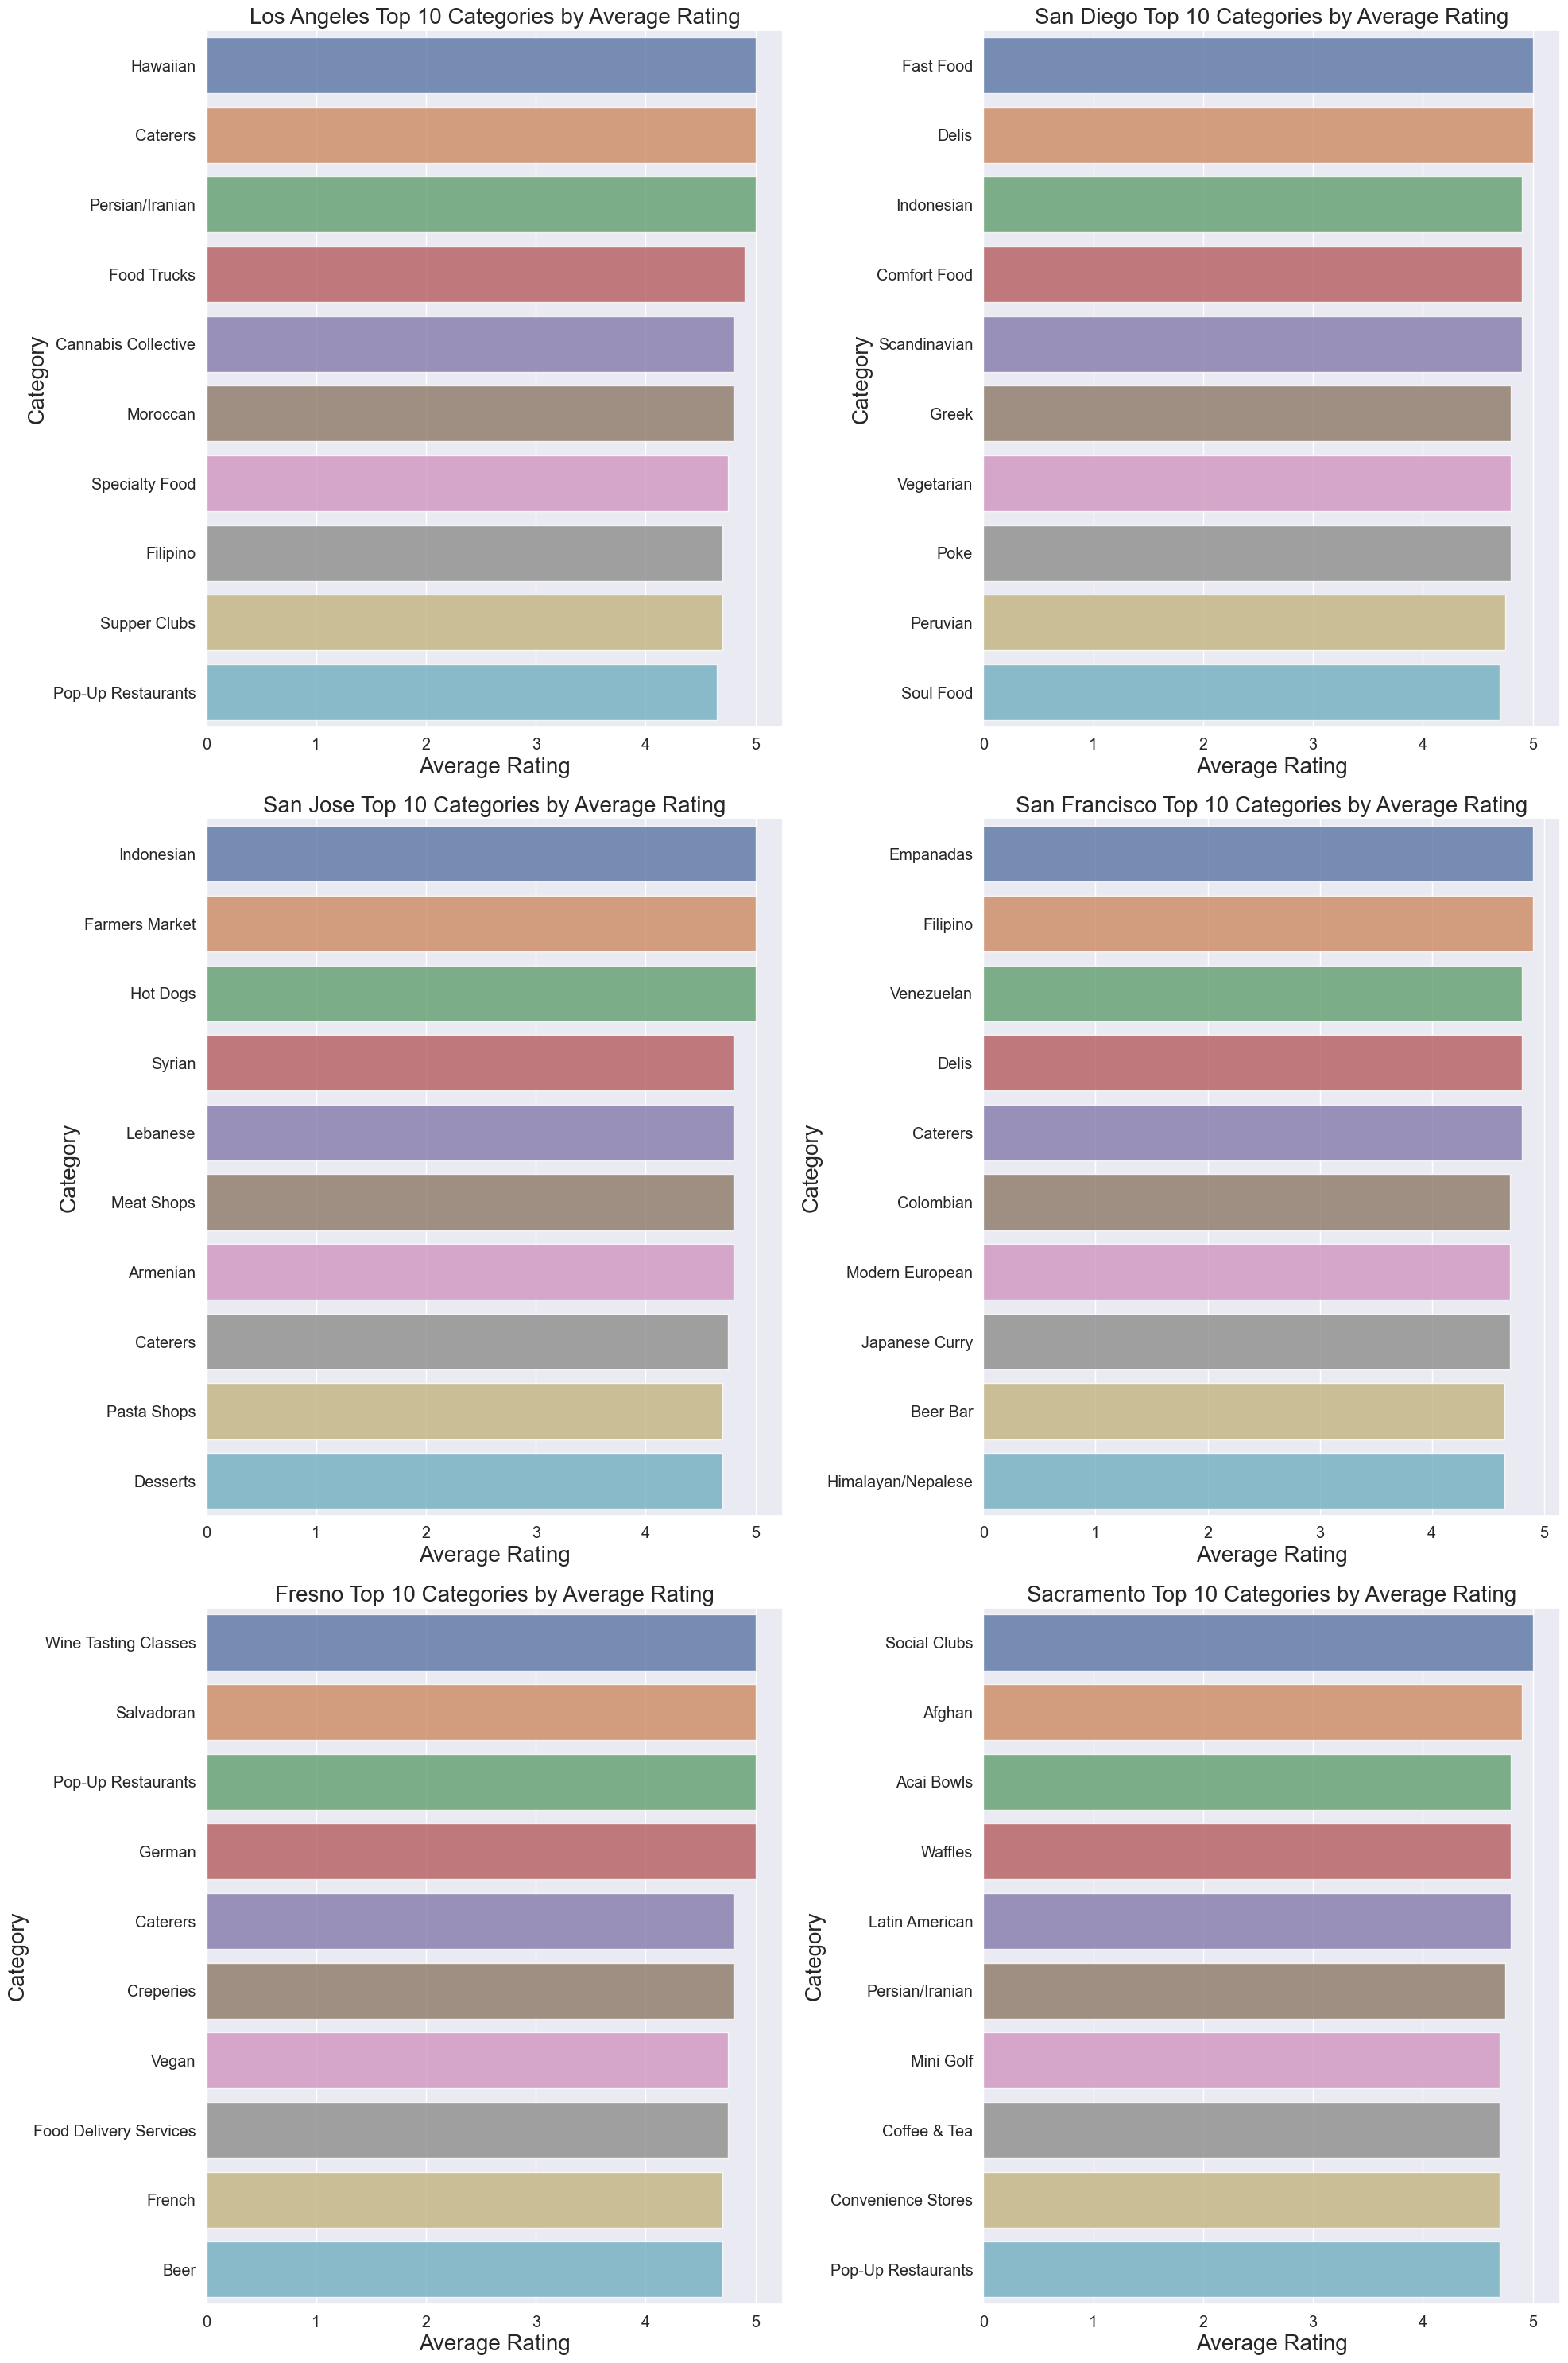

In [24]:
# Plotting average ratings received for different restaurants that fall under different word categories by city
cities_data = {
    "Los Angeles": LA_data_clean,
    "San Diego": San_Diego_data_clean,
    "San Jose": San_Jose_data_clean,
    "San Francisco": San_Fransisco_data_clean,
    "Fresno": Fresno_data_clean,
    "Sacramento": Sacramento_data_clean,
}

plt.figure(figsize=(20, 30))
for index, (city_name, city_data) in enumerate(cities_data.items(), start=1):
    plt.subplot(3, 2, index)
    frequency_of_categories_plotter = CategoryFrequencyPlotter(city_data)
    frequency_of_categories_plotter.plot_average_ratings(top_n=10, title_font_size=20, chart_title=f"{city_name} Top 10 Categories by Average Rating")

plt.tight_layout()
plt.savefig('../Images/8_bar_top_10_word_categories_by_ratings_by_city_1.png')
plt.show()

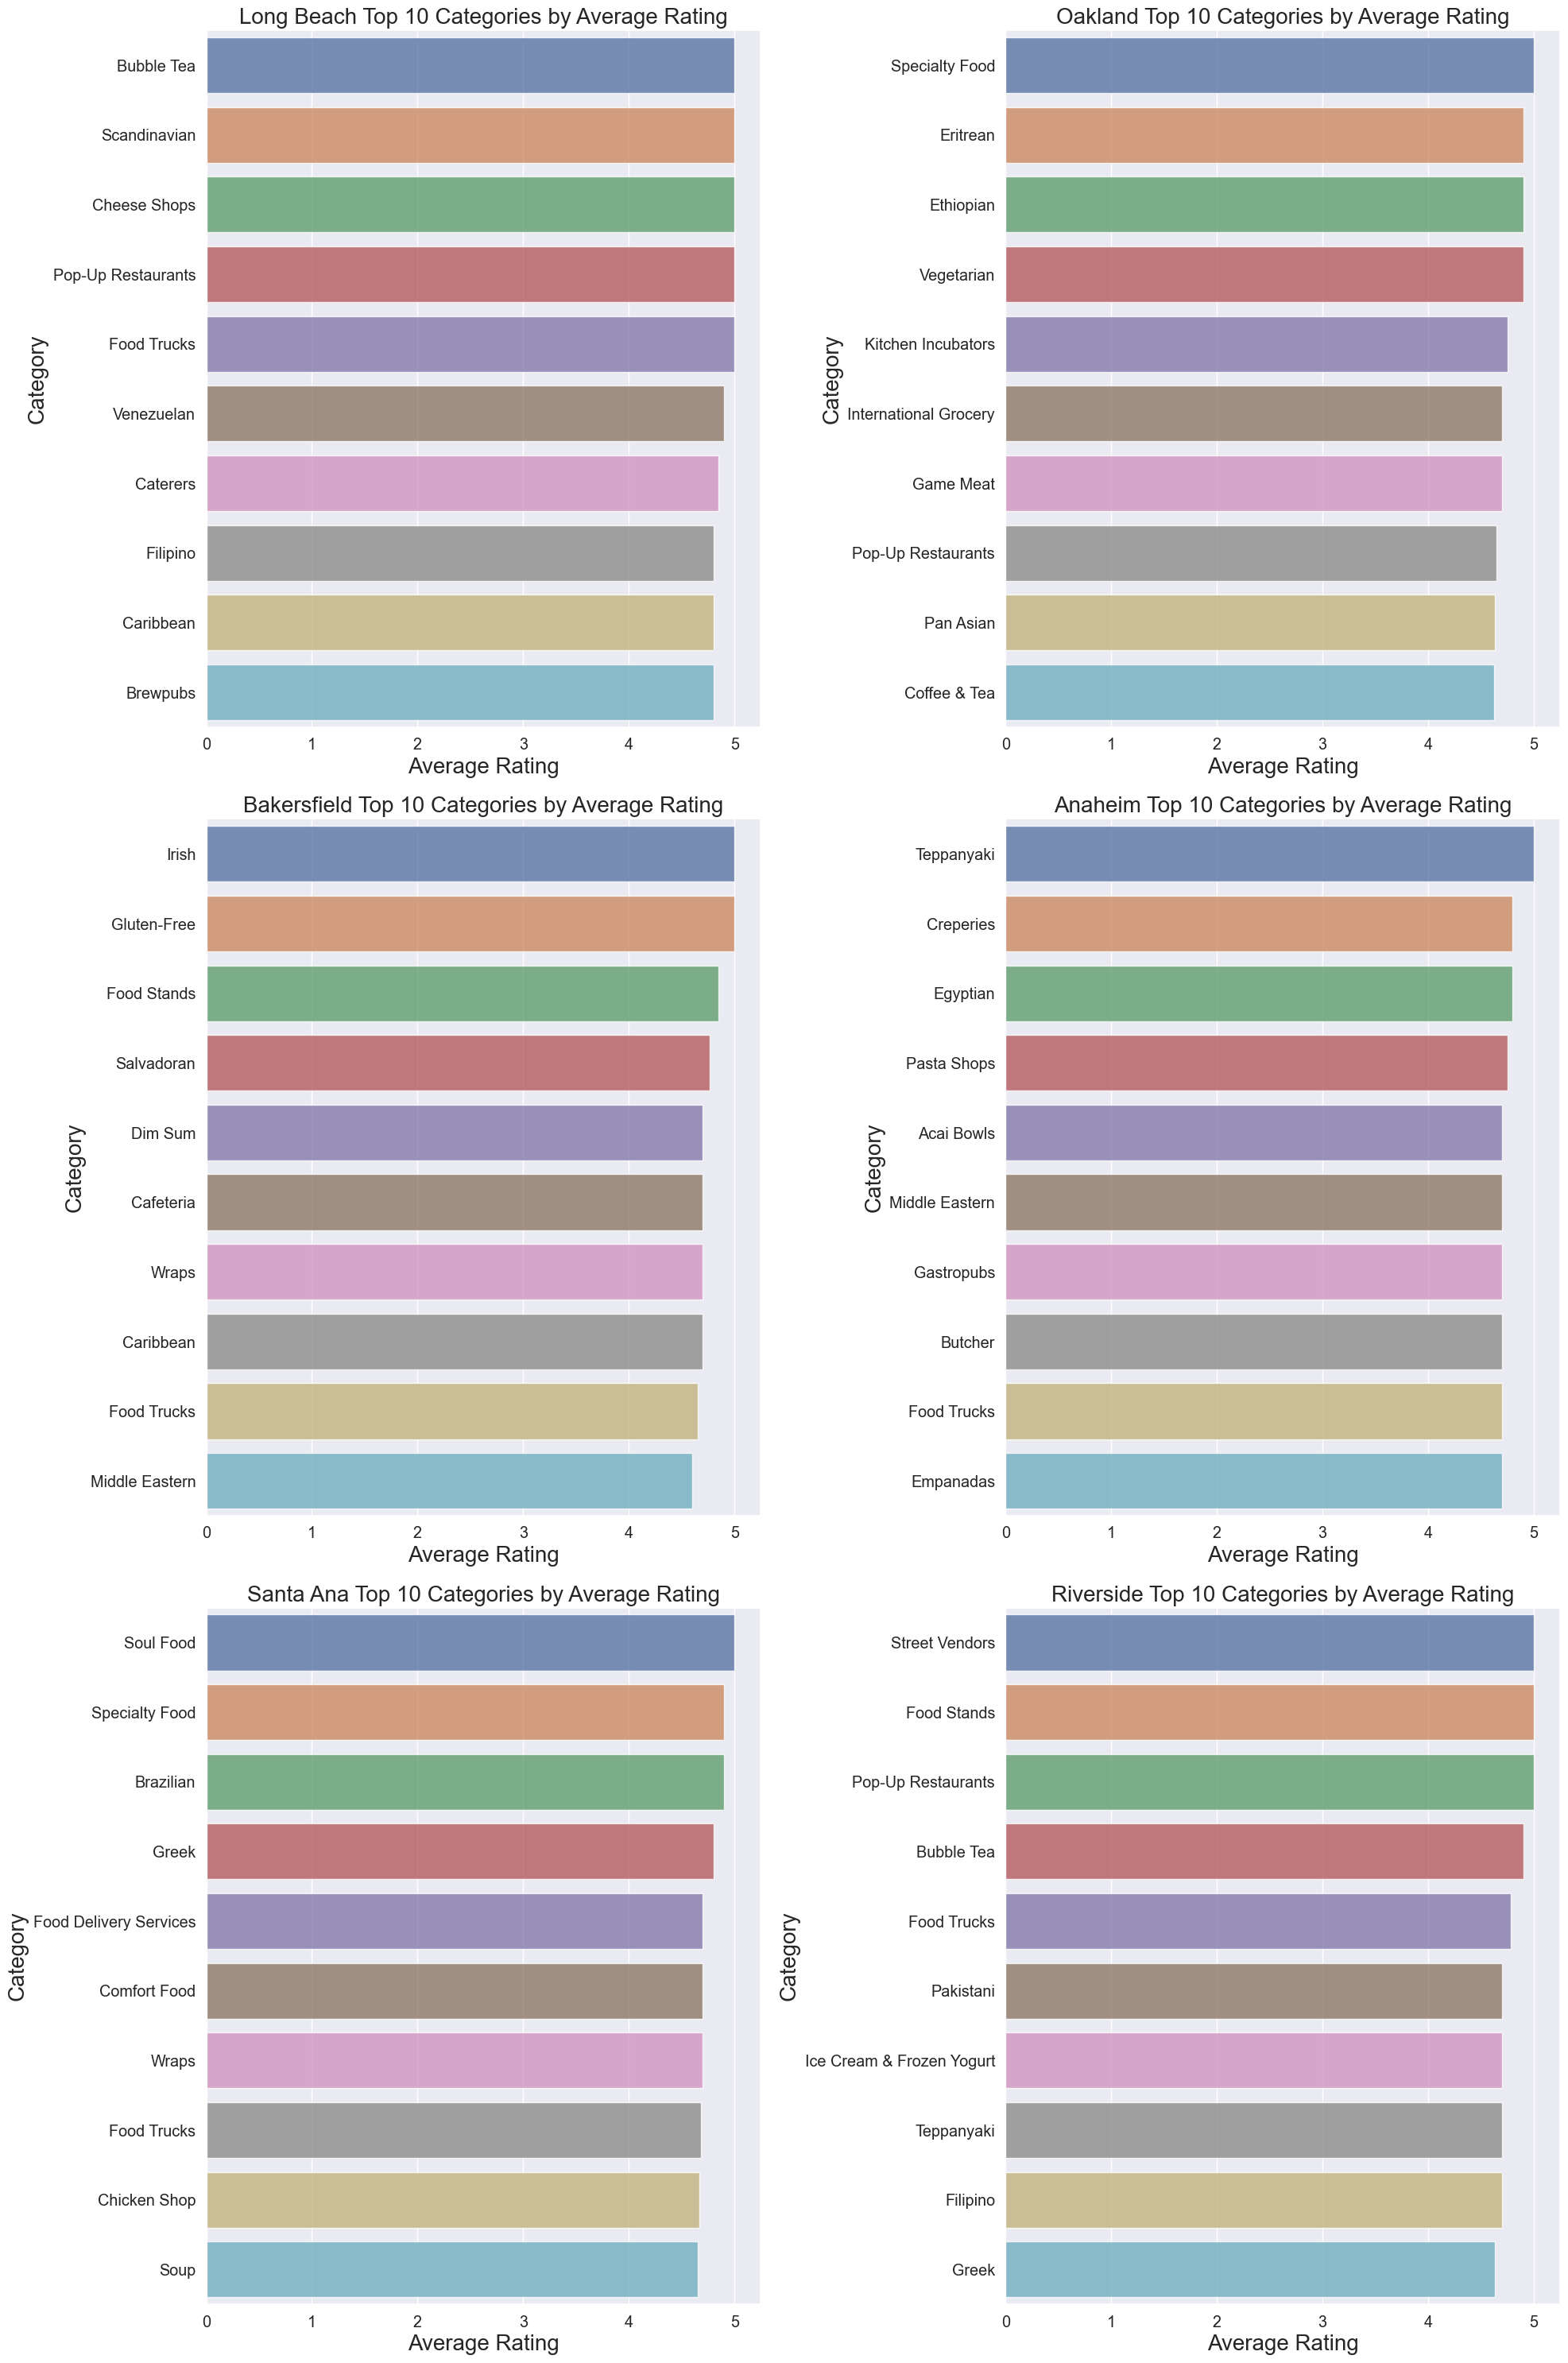

In [25]:
# Plotting average ratings received for different restaurants that fall under different word categories for the remaining cities
sns.set(font_scale=1.3)
cities_data = {
    "Long Beach": Long_Beach_data_clean,
    "Oakland": Oakland_data_clean,
    "Bakersfield": Bakersfield_data_clean,
    "Anaheim": Anaheim_data_clean,
    "Santa Ana": Santa_Ana_data_clean,
    "Riverside": Riverside_data_clean,
}

plt.figure(figsize=(20, 30))
for index, (city_name, city_data) in enumerate(cities_data.items(), start=1):
    plt.subplot(3, 2, index)
    frequency_of_categories_plotter = CategoryFrequencyPlotter(city_data)
    frequency_of_categories_plotter.plot_average_ratings(top_n=10, title_font_size=20, chart_title=f"{city_name} Top 10 Categories by Average Rating")

plt.tight_layout()
plt.savefig('../Images/9_bar_top_10_word_categories_by_ratings_by_city_2.png')
plt.show()

### Top 10 Word Categories w.r.t to Total Number of Reviews

In [26]:
# Apply preprocessing to sub dataframes
LA_data_clean['Rating'] = LA_data_clean['Rating'].apply(extract_ratings)
San_Diego_data_clean['Rating'] = San_Diego_data_clean['Rating'].apply(extract_ratings)
San_Jose_data_clean['Rating'] = San_Jose_data_clean['Rating'].apply(extract_ratings)
San_Fransisco_data_clean['Rating'] = San_Fransisco_data_clean['Rating'].apply(extract_ratings)
Fresno_data_clean['Rating'] = Fresno_data_clean['Rating'].apply(extract_ratings)
Sacramento_data_clean['Rating'] = Sacramento_data_clean['Rating'].apply(extract_ratings)
Anaheim_data_clean['Rating'] = Anaheim_data_clean['Rating'].apply(extract_ratings)
Long_Beach_data_clean['Rating'] = Long_Beach_data_clean['Rating'].apply(extract_ratings)
Oakland_data_clean['Rating'] = Oakland_data_clean['Rating'].apply(extract_ratings)
Bakersfield_data_clean['Rating'] = Bakersfield_data_clean['Rating'].apply(extract_ratings)
Santa_Ana_data_clean['Rating'] = Santa_Ana_data_clean['Rating'].apply(extract_ratings)
Riverside_data_clean['Rating'] = Riverside_data_clean['Rating'].apply(extract_ratings)

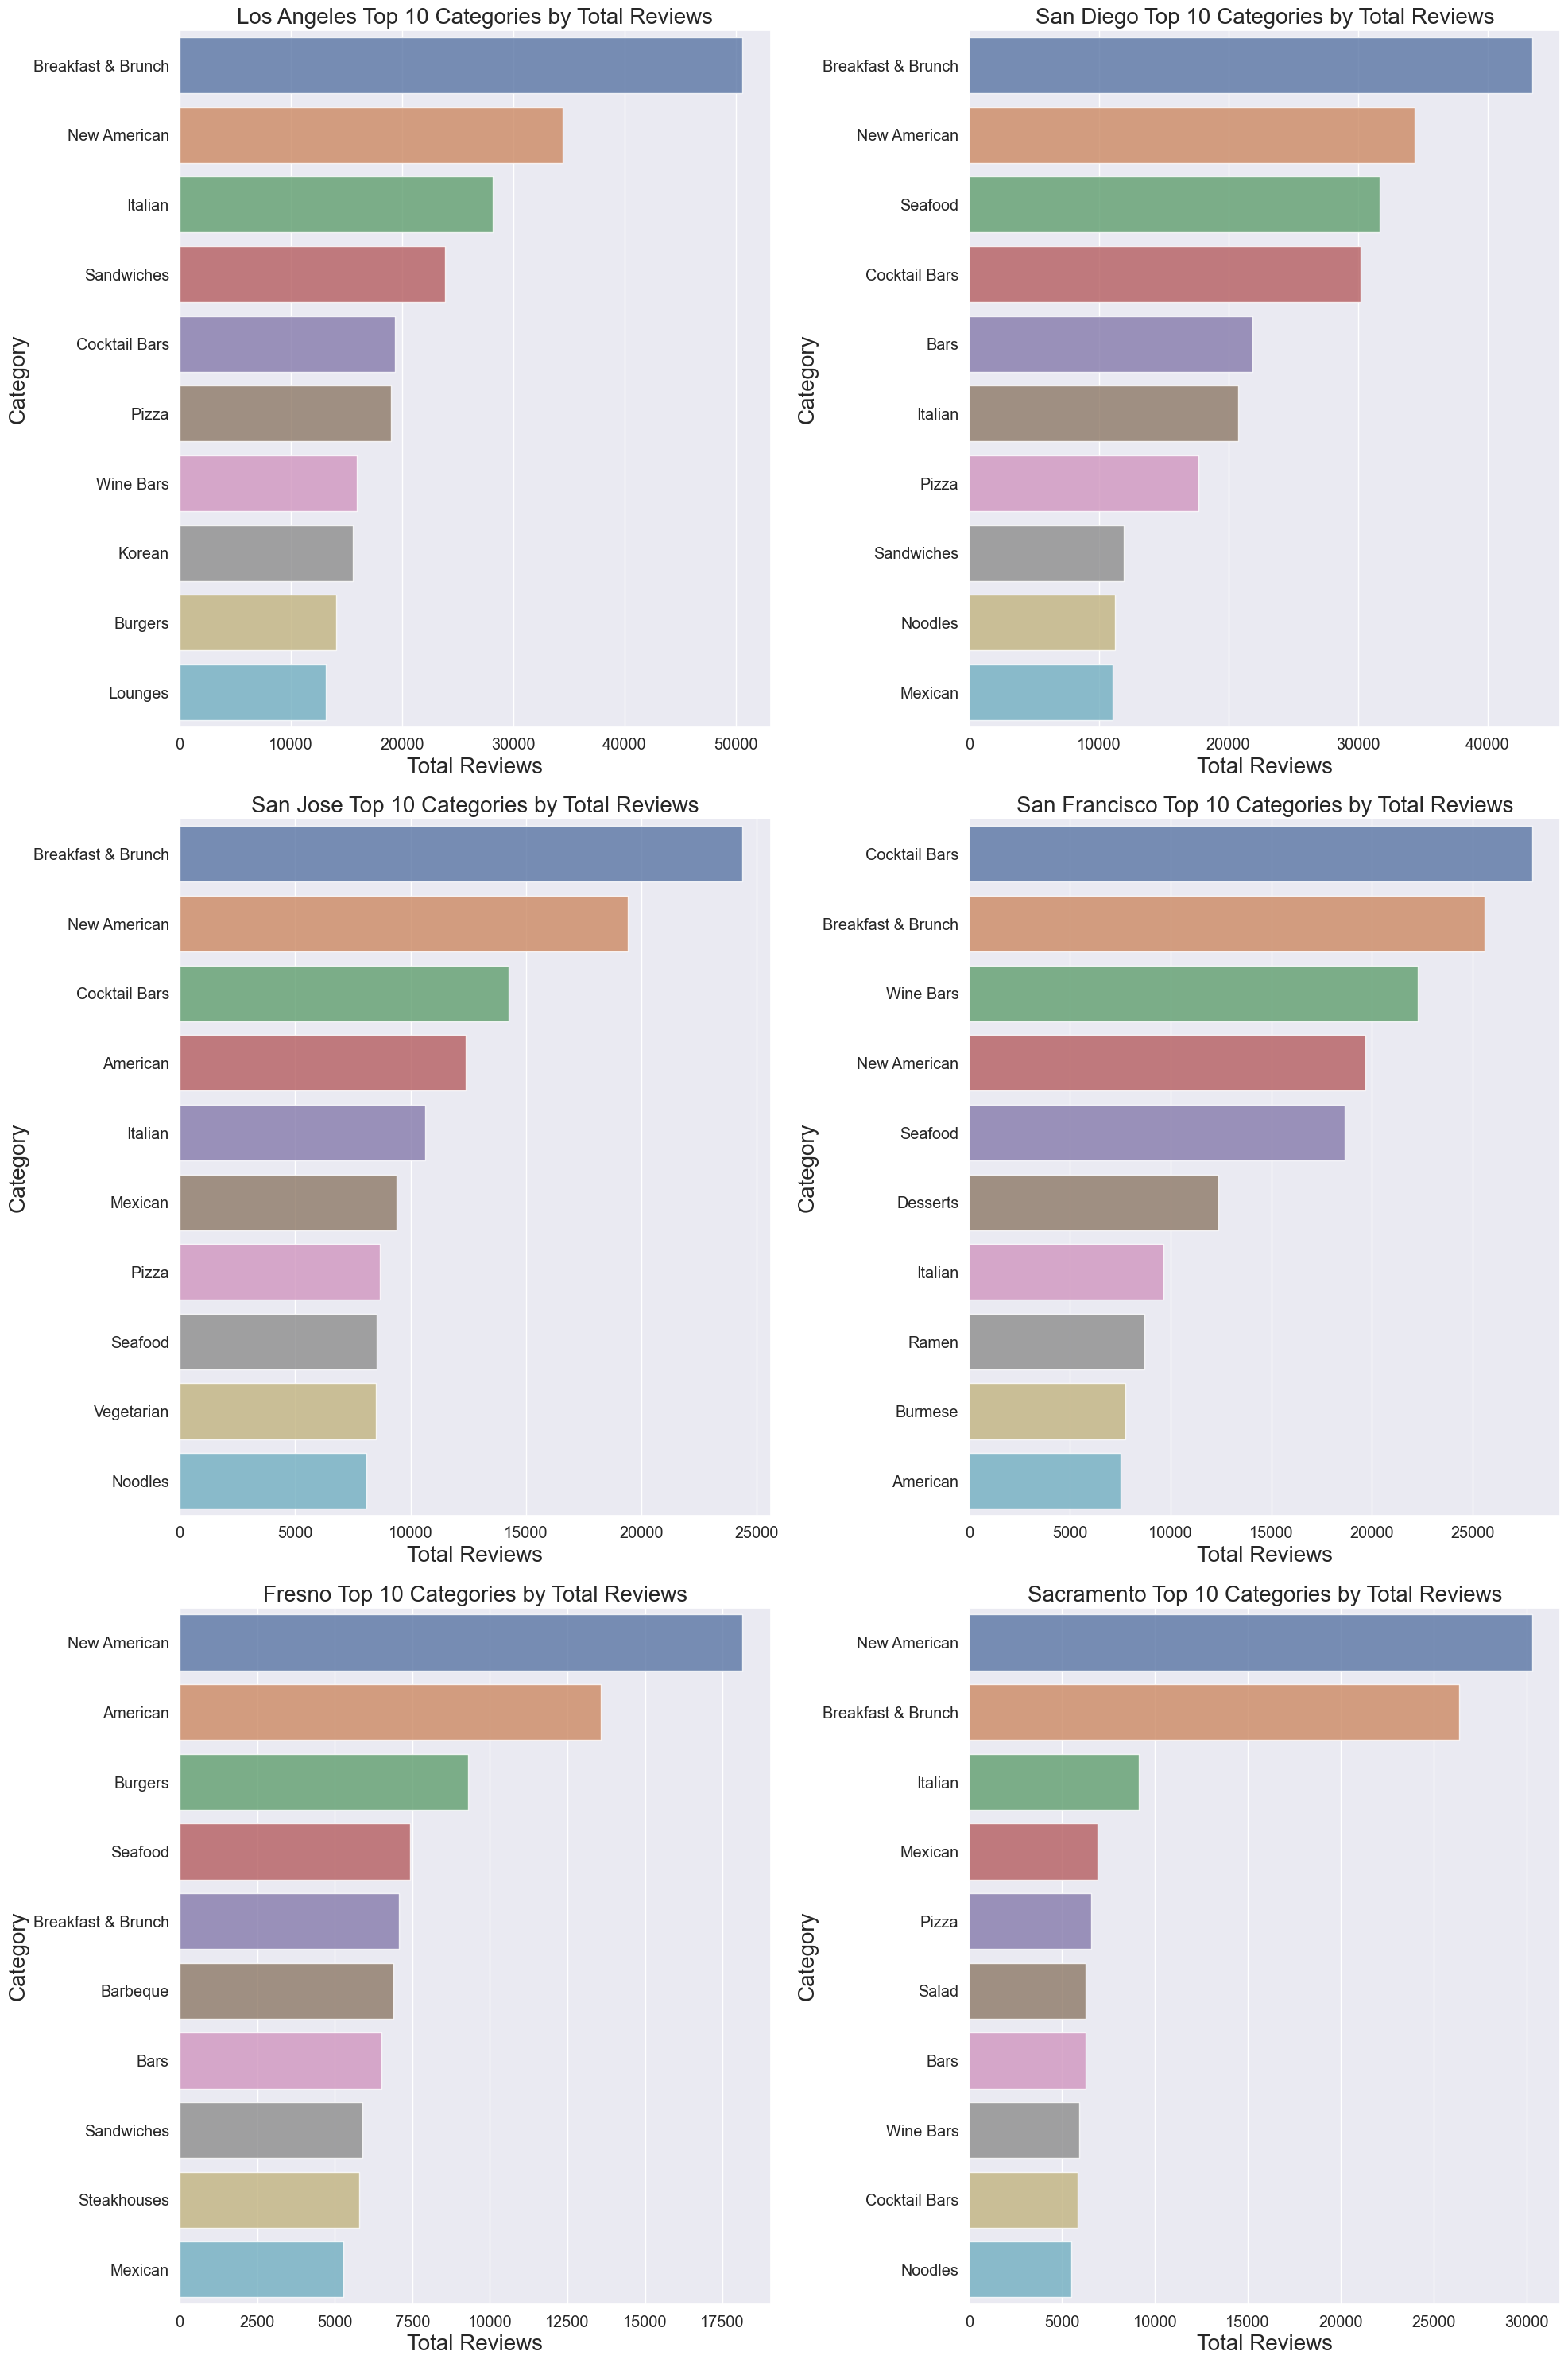

In [27]:
# Plotting the number of reviews received for different restaurants that fall under different word categories by cities
cities_data = {
    "Los Angeles": LA_data_clean,
    "San Diego": San_Diego_data_clean,
    "San Jose": San_Jose_data_clean,
    "San Francisco": San_Fransisco_data_clean,
    "Fresno": Fresno_data_clean,
    "Sacramento": Sacramento_data_clean,
}

plt.figure(figsize=(20, 30))
for index, (city_name, city_data) in enumerate(cities_data.items(), start=1):
    plt.subplot(3, 2, index)
    frequency_of_categories_plotter = CategoryFrequencyPlotter(city_data)
    frequency_of_categories_plotter.plot_total_reviews(top_n=10, title_font_size=20, chart_title=f"{city_name} Top 10 Categories by Total Reviews")
plt.tight_layout()

plt.savefig('../Images/10_bar_top_10_word_categories_by_reviews_by_city_1.png')
plt.show()

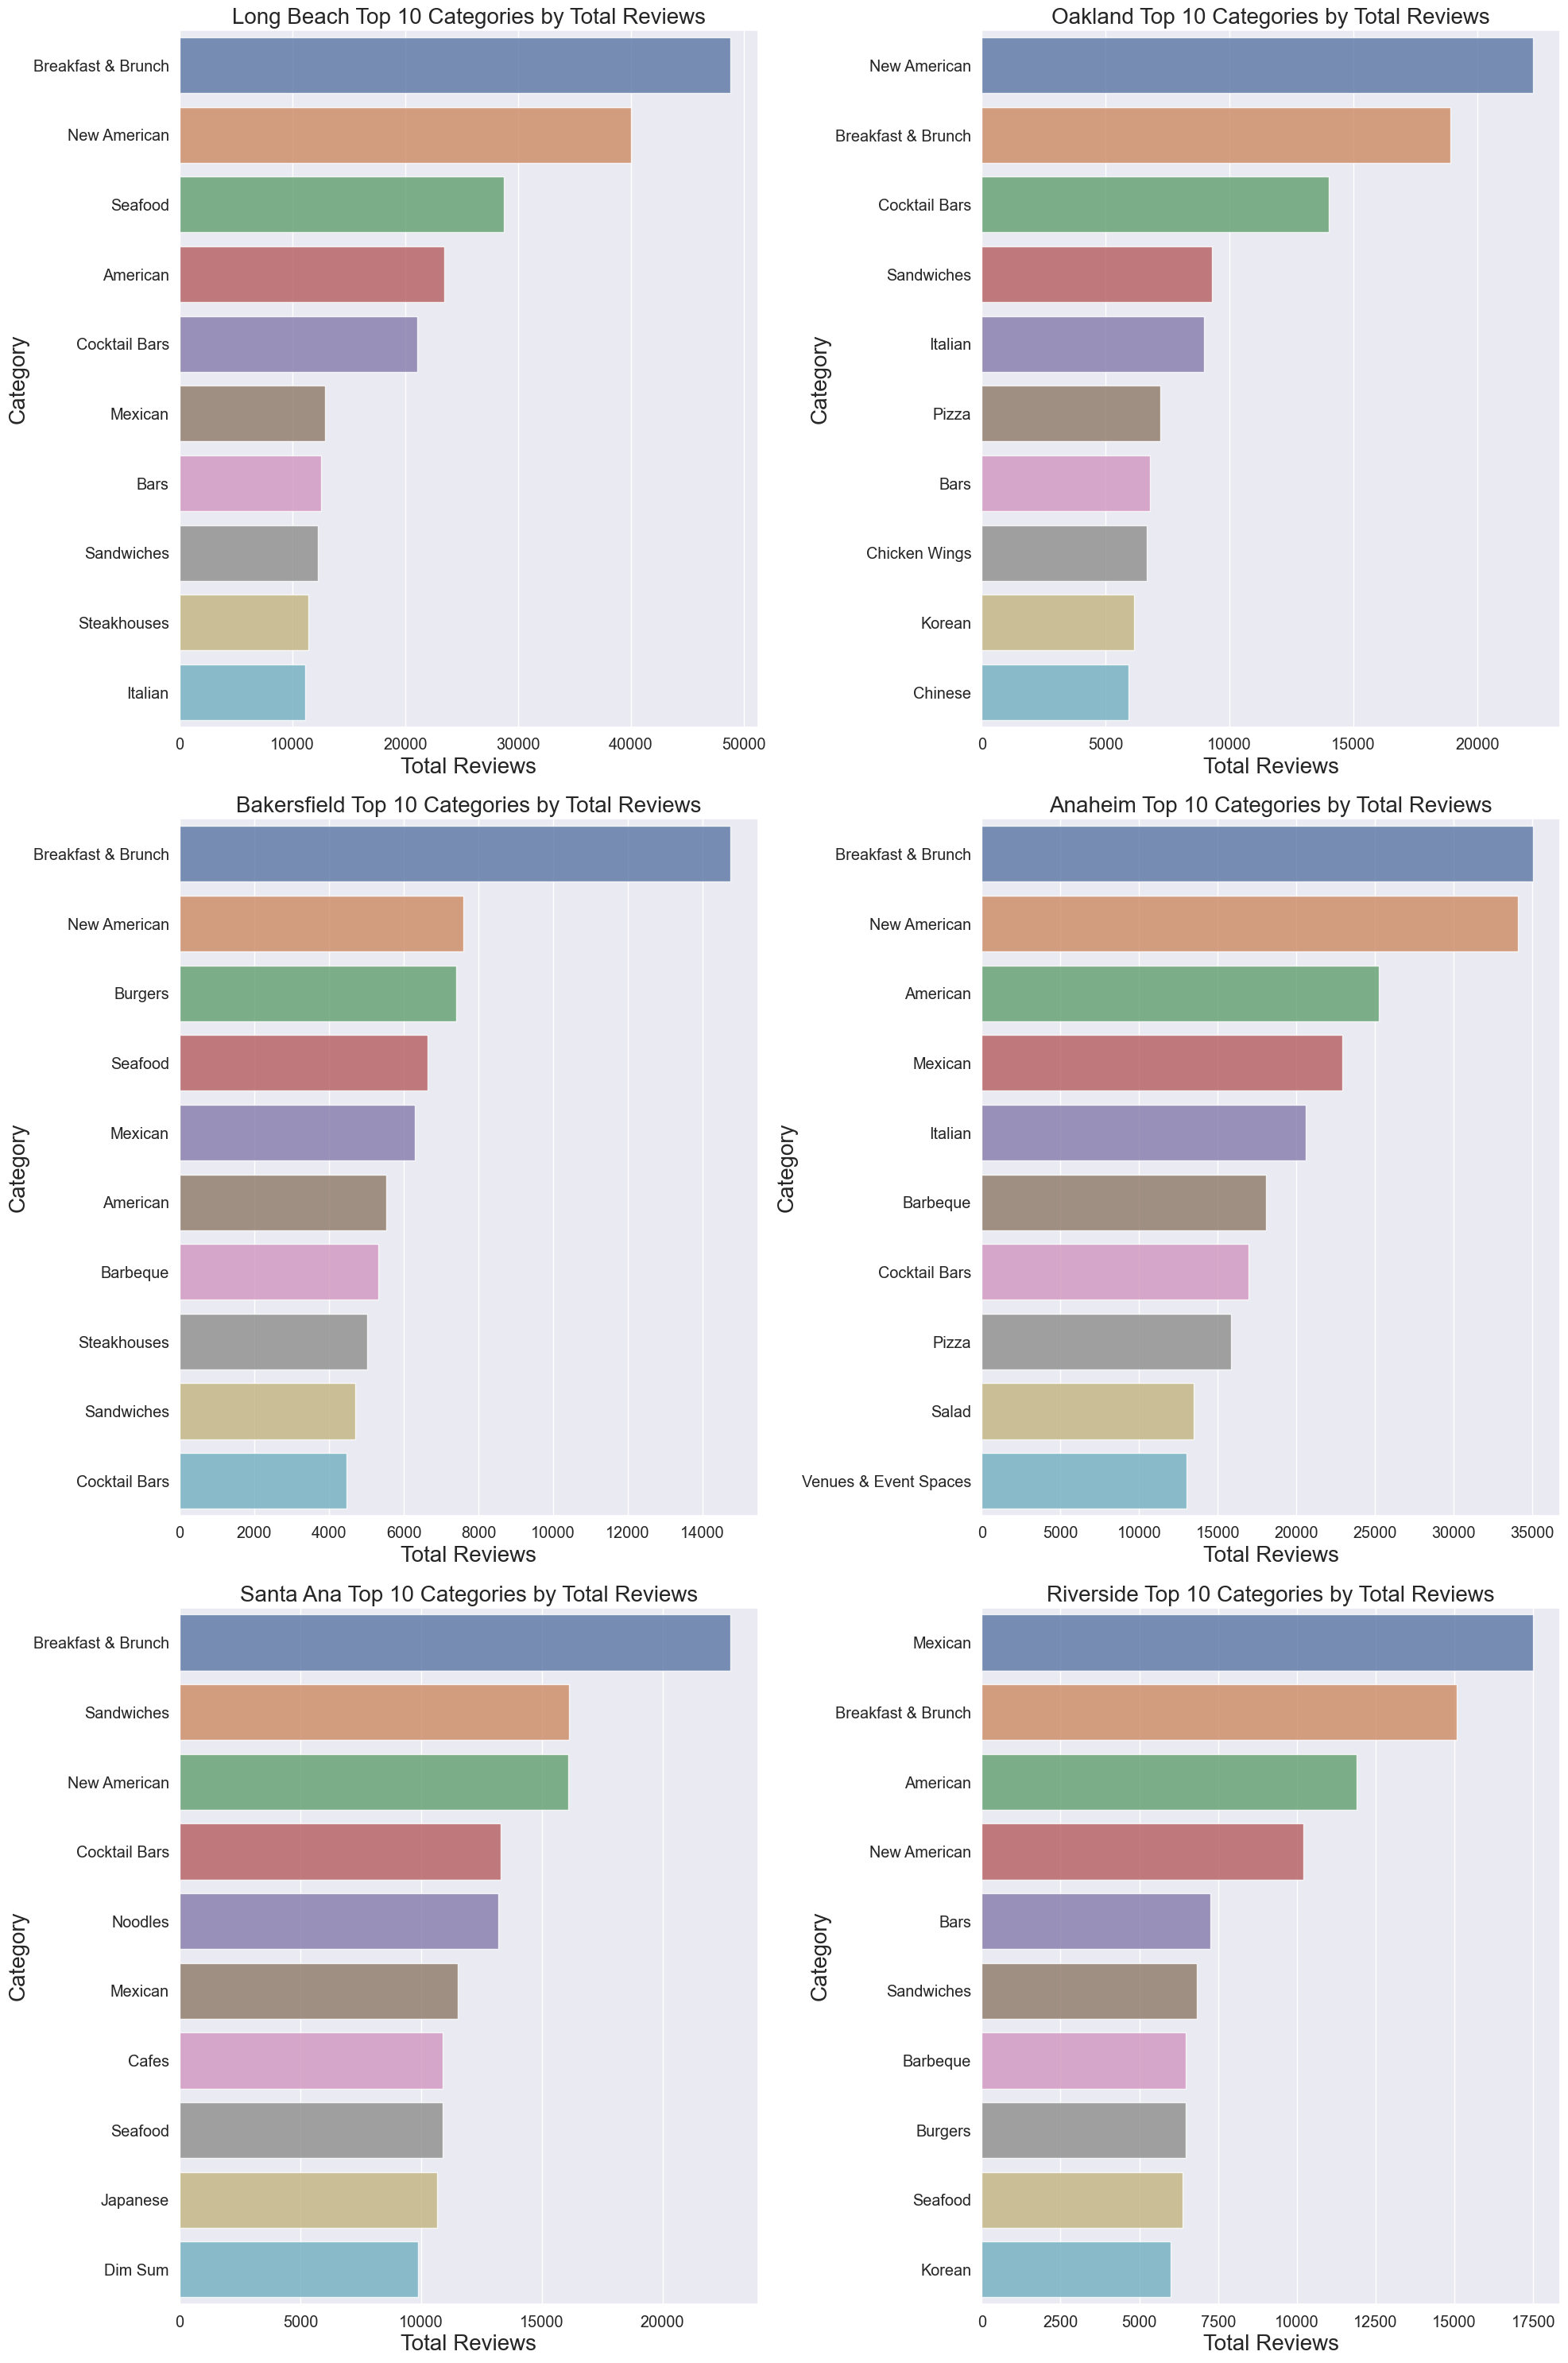

In [28]:
# Plotting the number of reviews received for different restaurants that fall under different word categories for ther remaining cities
cities_data = {
    "Long Beach": Long_Beach_data_clean,
    "Oakland": Oakland_data_clean,
    "Bakersfield": Bakersfield_data_clean,
    "Anaheim": Anaheim_data_clean,
    "Santa Ana": Santa_Ana_data_clean,
    "Riverside": Riverside_data_clean,
}

plt.figure(figsize=(20, 30))
for index, (city_name, city_data) in enumerate(cities_data.items(), start=1):
    plt.subplot(3, 2, index)
    frequency_of_categories_plotter = CategoryFrequencyPlotter(city_data)
    frequency_of_categories_plotter.plot_total_reviews(top_n=10, title_font_size=20, chart_title=f"{city_name} Top 10 Categories by Total Reviews")
plt.tight_layout()

plt.savefig('../Images/11_bar_top_10_word_categories_by_reviews_by_city_2.png')
plt.show()

### Word Cloud

In [29]:
Final_DataFrame_Combined["Category"]

1                              Korean
2        Korean, Specialty Food, Soup
3       Izakaya, Sushi Bars, Beer Bar
4                   Delis, Sandwiches
5       Italian, Pizza, Cocktail Bars
                    ...              
2226                 Mexican, Seafood
2227                       Vietnamese
2228       Grocery, Delis, Meat Shops
2229                            Tacos
2230     American, Breakfast & Brunch
Name: Category, Length: 2230, dtype: object

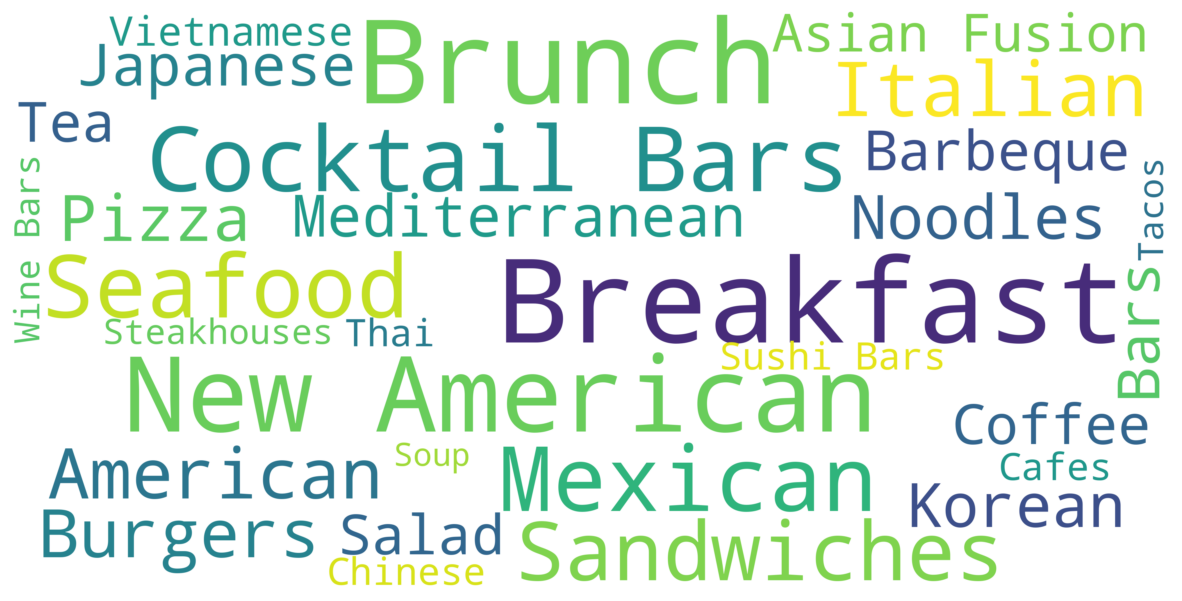

In [30]:
# Plot word cloud of different categories
Frequecy_of_categories = CategoryFrequencyPlotter(Final_DataFrame_Combined)
Frequecy_of_categories.count_categories()
Frequecy_of_categories.generate_wordcloud(max_words=30)
plt.savefig('../Images/12_wordcloud_word_categories.png')

### Part III: Restaurants operation hours analysis


In [31]:
def OpeningTime(time_str):
    '''
    Function to process and extract opening times of restaurants
    '''
    if time_str == None:
        return None
    if time_str == 'Closed':
         return 'Closed'
    # print("Actual string", time_str)
    components = str(time_str[0][0]).split()
    # print("time_str:",components)
    # print("Opening component:",type(components[0]))
    opening_hour_component = str(components[0]).split(':')
    if len(opening_hour_component) != 2:
        return "Closed"
    opening_hour, opening_minute = map(int, opening_hour_component)
    if 'PM' in components[1] and opening_hour != 12:
        opening_hour += 12
    opening_minute = opening_minute if opening_minute != 0 else '00'
    return str(opening_hour)+":"+str(opening_minute)

time_str = [['3:00 PM - 9:30 PM']]
hour_24_format = OpeningTime(time_str)
print(hour_24_format)

15:00


In [32]:
def ClosingTime(time_str):
    '''
    Function to process and extract closing times of restaurants
    '''
    if time_str == None or time_str=="Unknown":
        return 'No Info'
    if time_str == 'Closed':
        return 'Closed'

    try:
        # print("Actual string", time_str)
        components = str(time_str[0][1]).split()
        # print("time_str:",components)
        # print("closing component:",components[0])
    except:
        components = str(time_str).split(" - ")[-1].split()[0:2]
        # print(time_str, "################", components)
  
    closing_hour_component = str(components[0]).split(':')
    if len(closing_hour_component) != 2:
        return "Closed"
    closing_hour, closing_minute = map(int, closing_hour_component)
    if 'PM' in components[1] and closing_hour != 12:
        closing_hour += 12
    closing_minute = closing_minute if closing_minute != 0 else '00'
    return str(closing_hour)+":"+str(closing_minute)

time_str = [['9:00 PM ','10:30 PM']]
time_str = [['7:00 AM ','11:00 AM']]
closing_hour_24 = ClosingTime(time_str)
print(closing_hour_24) 

11:00


In [33]:
# Generate opening times of different days of the week
Final_DataFrame_Combined[['MonOpen', 'TueOpen', 'WedOpen', 'ThuOpen', 'FriOpen', 'SatOpen', 
                          'SunOpen']] = Final_DataFrame_Combined[['Mon', 'Tue', 'Wed', 
                                                                  'Thu', 'Fri', 'Sat', 'Sun']].applymap(OpeningTime)

# Generate opening times of different days of the week
Final_DataFrame_Combined[['MonClose', 'TueClose', 'WedClose', 'ThuClose', 'FriClose', 'SatClose', 
                          'SunClose']] = Final_DataFrame_Combined[['Mon', 'Tue', 'Wed', 
                                                                   'Thu', 'Fri', 'Sat', 'Sun']].applymap(ClosingTime)
# Final combined dataframe
Final_DataFrame_Combined.head()

,index,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,...,FriOpen,SatOpen,SunOpen,MonClose,TueClose,WedClose,ThuClose,FriClose,SatClose,SunClose
1,1,Jinsol Gukbap 8th,"3428 W 8th St Los Angeles, CA 90005",Korean,$$,66,4.8,10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),...,Closed,Closed,Closed,2:30,2:30,2:30,2:30,2:30,2:30,2:30
2,2,Cooking Mom,"3660 Wilshire Blvd Ste 120 Los Angeles, CA 90010","Korean, Specialty Food, Soup",$$,36,4.8,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,...,Closed,Closed,Closed,17:30,17:30,17:30,17:30,17:30,Closed,Closed
3,3,Budonoki,"654 N Virgil Ave Los Angeles, CA 90004","Izakaya, Sushi Bars, Beer Bar",Unknown,76,4.6,Closed,Closed,5:30 PM - 10:00 PM,...,Closed,Closed,Closed,Closed,Closed,22:00,22:00,22:00,22:00,22:00
4,4,Langer's Delicatessen,"704 S Alvarado St Los Angeles, CA 90057","Delis, Sandwiches",$$,4520,4.4,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,...,Closed,Closed,Closed,16:00,16:00,16:00,16:00,16:00,16:00,Closed
5,5,Osteria La Buca,"5210 Melrose Ave Los Angeles, CA 90038","Italian, Pizza, Cocktail Bars",$$,2293,4.1,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,...,Closed,Closed,Closed,14:30,14:30,14:30,14:30,14:30,23:00,14:30


### Part IV: Top 25 restaurants reviews distribution analysis based on cities 

In [49]:
# Apply precossing steps
Final_DataFrame_Combined['Reviews'] = pd.to_numeric(Final_DataFrame_Combined['Reviews'], errors='coerce').fillna(0)
Final_DataFrame_Combined.loc[Final_DataFrame_Combined['Reviews'] == 'Unknown', 'Reviews'] = 0
Final_DataFrame_Combined['Reviews'] = Final_DataFrame_Combined['Reviews'].astype(float)
Final_DataFrame_Combined.head()
# Final_DataFrame_Combined.shape

,index,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,...,SatOpen,SunOpen,MonClose,TueClose,WedClose,ThuClose,FriClose,SatClose,SunClose,ReviewRatings
1,1,Jinsol Gukbap 8th,"3428 W 8th St Los Angeles, CA 90005",Korean,$$,66,4.8,10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),...,Closed,Closed,2:30,2:30,2:30,2:30,2:30,2:30,2:30,4.8
2,2,Cooking Mom,"3660 Wilshire Blvd Ste 120 Los Angeles, CA 90010","Korean, Specialty Food, Soup",$$,36,4.8,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,...,Closed,Closed,17:30,17:30,17:30,17:30,17:30,Closed,Closed,4.8
3,3,Budonoki,"654 N Virgil Ave Los Angeles, CA 90004","Izakaya, Sushi Bars, Beer Bar",Unknown,76,4.6,Closed,Closed,5:30 PM - 10:00 PM,...,Closed,Closed,Closed,Closed,22:00,22:00,22:00,22:00,22:00,4.6
4,4,Langer's Delicatessen,"704 S Alvarado St Los Angeles, CA 90057","Delis, Sandwiches",$$,4520,4.4,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,...,Closed,Closed,16:00,16:00,16:00,16:00,16:00,16:00,Closed,4.4
5,5,Osteria La Buca,"5210 Melrose Ave Los Angeles, CA 90038","Italian, Pizza, Cocktail Bars",$$,2293,4.1,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,...,Closed,Closed,14:30,14:30,14:30,14:30,14:30,23:00,14:30,4.1


In [35]:
# Extract data for top 25 most popular restaurants by number of reviews
Freq_rev_df = Final_DataFrame_Combined.sort_values('Rating', ascending=False)
v = Freq_rev_df['Name'].values.tolist()[0:25]
d = Freq_rev_df['Rating'].values.tolist()[0:25]
color_series = ['#FAE927','#E9E416','#C9DA36','#9ECB3C','#6DBC49',
                '#37B44E','#3DBA78','#14ADCF','#209AC9','#1E91CA',
                '#2C6BA0','#2B55A1','#2D3D8E','#44388E','#7D3990',
                '#A63F98','#C31C88','#D52178','#D5225B','#D02C2A',
                '#D44C2D','#F57A34','#FA8F2F','#D99D21','#CF7B25']

In [36]:
Freq_rev_df.head()

,index,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,...,FriOpen,SatOpen,SunOpen,MonClose,TueClose,WedClose,ThuClose,FriClose,SatClose,SunClose
46,48,Perch,"448 S Hill St Los Angeles, CA 90013","Lounges, French, Breakfast & Brunch",$$$,10284,4.1,4:00 PM - 1:00 AM (Next day),4:00 PM - 1:00 AM (Next day),4:00 PM - 1:00 AM (Next day),...,Closed,Closed,Closed,1:00,1:00,1:00,2:00,2:00,15:30,15:30
548,574,Fog Harbor Fish House,"39 Pier Ste 202A San Francisco, CA 94133","Seafood, Wine Bars, Cocktail Bars",$$,10230,4.3,11:00 AM - 9:00 PM,11:00 AM - 9:00 PM,11:00 AM - 9:00 PM,...,Closed,Closed,Closed,21:00,21:00,21:00,21:00,21:00,21:00,21:00
1843,1959,Craft By Smoke & Fire - Anaheim,"195 W Center St Promenade Anaheim, CA 92805","Barbeque, Cocktail Bars, American",$$,9676,4.7,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,...,Closed,Closed,Closed,22:00,22:00,22:00,22:00,12:00,12:00,22:00
339,355,"Snooze, an A.M. Eatery","3940 Fifth Ave San Diego, CA 92103","Breakfast & Brunch, American, Cocktail Bars",$$,8517,4.4,6:30 AM - 2:30 PM,6:30 AM - 2:30 PM,6:30 AM - 2:30 PM,...,Closed,Closed,Closed,14:30,14:30,14:30,14:30,14:30,16:00,16:00
71,74,Morrison Atwater Village,"3179 Los Feliz Blvd Los Angeles, CA 90039","Gastropubs, Burgers, Salad",$$,7722,4.6,12:00 PM - 9:00 PM,12:00 PM - 9:00 PM,12:00 PM - 9:00 PM,...,Closed,Closed,Closed,21:00,21:00,21:00,22:00,23:00,23:00,21:00


In [37]:
# Generate pie chart for top 25 most popular restaurants by number of reviews
pie1 = Pie(init_opts=opts.InitOpts(width='800px', height='500px'))
pie1.set_colors(color_series)
pie1.add("", [list(z) for z in zip(v, d)],
        radius=["30%", "135%"],
        center=["50%", "65%"],
        rosetype="area")
pie1.set_global_opts(title_opts=opts.TitleOpts(title='Top 25 most popular restaurants with most reviews'),
                     legend_opts=opts.LegendOpts(is_show=False),
                     toolbox_opts=opts.ToolboxOpts())
pie1.set_series_opts(label_opts=opts.LabelOpts(is_show=True, position="inside", font_size=12,
                                               formatter="{b}:{c}", font_style="italic",
                                               font_weight="bold"))

# pie1.render('../Images/13_top25_most_popular_restaurants_with_most_reviews.html')
pie1.render_notebook()

**Observations and Comments:**

- The plot above showed top 25 most reviewed restaurants by this Archimedean spiral-liked plot.

We would like perfrom some further analysis combined graphical methods on these top 25 restaurants, and we before with a list of these ideal restaurants:

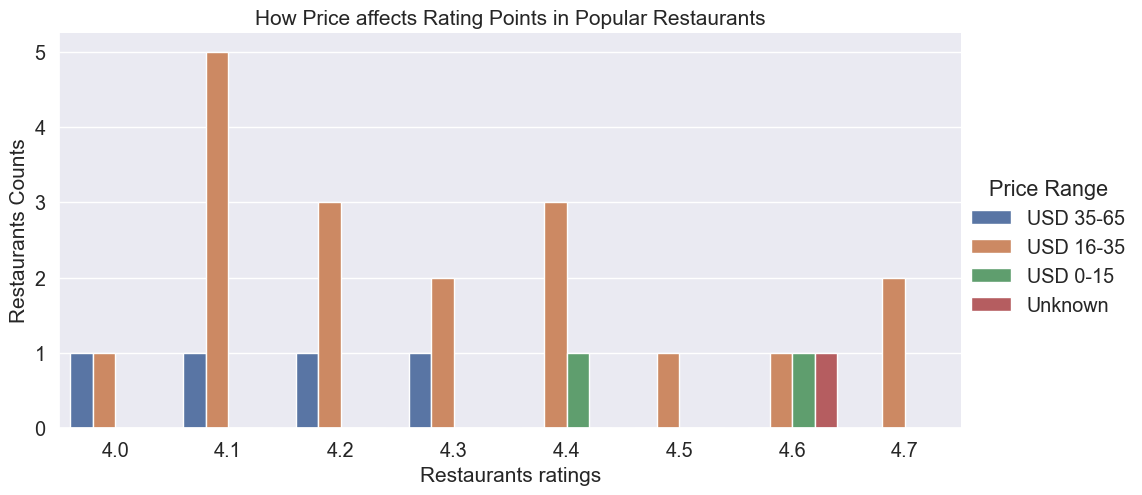

In [38]:
# Plot effect of ratings w.r.t price category of the restaurants
Freq_rev_df['Price_for_plot'] = Freq_rev_df['Price'].replace({'\$\$\$': 'USD 35-65', '\$\$': 'USD 16-35', '\$': 'USD 0-15'}, regex=True)
Freq_rev_df['Price Range'] = Freq_rev_df['Price_for_plot']
sns.set(rc={'figure.figsize':(25, 25)})
sns.set(font_scale=1.3)
cat_plot = sns.catplot(x='Reviews', hue='Price Range', kind='count', data=Freq_rev_df[:25], height=5, aspect=2)
plt.ylabel('Restaurants Counts', fontsize=15)
plt.xlabel('Restaurants ratings', fontsize=15)
plt.title('How Price affects Rating Points in Popular Restaurants', fontsize=15)
plt.savefig('../Images/14_top25_effect_of_price_with_ratings.png')
plt.show()

### Part V: Restaurants geo-spatial analysis 

In [39]:
# DataFrame Operations: Manipulate and analyze data using pandas.
Final_DataFrame_Combined.head()

,index,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,...,FriOpen,SatOpen,SunOpen,MonClose,TueClose,WedClose,ThuClose,FriClose,SatClose,SunClose
1,1,Jinsol Gukbap 8th,"3428 W 8th St Los Angeles, CA 90005",Korean,$$,66,4.8,10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),10:00 AM - 2:30 AM (Next day),...,Closed,Closed,Closed,2:30,2:30,2:30,2:30,2:30,2:30,2:30
2,2,Cooking Mom,"3660 Wilshire Blvd Ste 120 Los Angeles, CA 90010","Korean, Specialty Food, Soup",$$,36,4.8,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,10:00 AM - 5:30 PM,...,Closed,Closed,Closed,17:30,17:30,17:30,17:30,17:30,Closed,Closed
3,3,Budonoki,"654 N Virgil Ave Los Angeles, CA 90004","Izakaya, Sushi Bars, Beer Bar",Unknown,76,4.6,Closed,Closed,5:30 PM - 10:00 PM,...,Closed,Closed,Closed,Closed,Closed,22:00,22:00,22:00,22:00,22:00
4,4,Langer's Delicatessen,"704 S Alvarado St Los Angeles, CA 90057","Delis, Sandwiches",$$,4520,4.4,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,8:00 AM - 4:00 PM,...,Closed,Closed,Closed,16:00,16:00,16:00,16:00,16:00,16:00,Closed
5,5,Osteria La Buca,"5210 Melrose Ave Los Angeles, CA 90038","Italian, Pizza, Cocktail Bars",$$,2293,4.1,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,...,Closed,Closed,Closed,14:30,14:30,14:30,14:30,14:30,23:00,14:30


In [40]:
Final_DataFrame_Combined.columns

Index(['index', 'Name', 'Address', 'Category', 'Price', 'Rating', 'Reviews',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'ZIP', 'MonOpen',
       'TueOpen', 'WedOpen', 'ThuOpen', 'FriOpen', 'SatOpen', 'SunOpen',
       'MonClose', 'TueClose', 'WedClose', 'ThuClose', 'FriClose', 'SatClose',
       'SunClose'],
      dtype='object')

In [41]:
def intRating(item):
    '''
    Function to obtain numeric rating
    '''
    if item == 'Unknown':
        return 0
    return float(item)

# Apply preprocessing
Final_DataFrame_Combined['ReviewRatings'] = Final_DataFrame_Combined['Reviews'].apply(intRating)
Final_DataFrame_Combined['ZIP'] = Final_DataFrame_Combined['ZIP'].replace({'CA ': ''}, regex=True)
Postal_code_data = Final_DataFrame_Combined.groupby('ZIP', as_index=False)['ReviewRatings'].mean()
Postal_code_data = Postal_code_data[Postal_code_data['ZIP'] != 'Unknown'].astype(str)
Postal_code_data['ReviewRatings'] = Postal_code_data['ReviewRatings']
Postal_code_data.reset_index(drop=True, inplace=True)
Postal_code_data['ZIP'] = Postal_code_data['ZIP'].str.strip()
print(Postal_code_data.head())
print(Postal_code_data.columns)

     ZIP      ReviewRatings
0  90004  4.516666666666667
1  90005  4.446153846153846
2  90006                4.2
3  90007  4.699999999999999
4  90010               4.65
Index(['ZIP', 'ReviewRatings'], dtype='object')


In [42]:
# Read location data and merge it with existing dataframe to obtain counties
Locations_data = pd.read_csv('../Stored_Info/City_data/Extra_info.csv', dtype={'ZIP':str,'STCOUNTYFP':str})
Locations_data['ZIP'] = Locations_data['ZIP'].str.strip()
print(Locations_data[Locations_data["ZIP"]=="90004"].head())
scratch = Postal_code_data.merge(Locations_data, how='left', on='ZIP')
scratch = scratch.dropna()
scratch.head()

        ZIP STCOUNTYFP         CITY STATE          COUNTYNAME CLASSFP
3722  90004      06037  Los angeles    CA  Los Angeles County      H1


,ZIP,ReviewRatings,STCOUNTYFP,CITY,STATE,COUNTYNAME,CLASSFP
0,90004,4.516666666666667,06037,Los angeles,CA,Los Angeles County,H1
1,90005,4.446153846153846,06037,Los angeles,CA,Los Angeles County,H1
2,90006,4.2,06037,Los angeles,CA,Los Angeles County,H1
3,90007,4.699999999999999,06037,Los angeles,CA,Los Angeles County,H1
4,90010,4.65,06037,Los angeles,CA,Los Angeles County,H1


In [43]:
# Use geojson to get geo features to plot the data on USA map only for state=CA (code=06)
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
countyFeatures = counties['features']
needCountieFeatures= []
for sample in countyFeatures:
    if sample['properties']['STATE'] == '06':
        needCountieFeatures.append(sample)
plot_counties = {}
plot_counties['type'] = counties['type'] 
plot_counties['features'] = needCountieFeatures
# print(plot_counties)

In [44]:
scratch.head()
print(scratch.dtypes)
scratch['ReviewRatings'] = scratch['ReviewRatings'].astype(float).round(2)
print(scratch.dtypes)

ZIP              object
ReviewRatings    object
STCOUNTYFP       object
CITY             object
STATE            object
COUNTYNAME       object
CLASSFP          object
dtype: object
ZIP               object
ReviewRatings    float64
STCOUNTYFP        object
CITY              object
STATE             object
COUNTYNAME        object
CLASSFP           object
dtype: object


In [46]:
# If the figure doesn't get displayed please rerun the cell or refer to the /Images/
fig = px.choropleth(
    scratch,
    geojson=plot_counties,  
    locations='STCOUNTYFP',
    color='ReviewRatings',
    color_continuous_scale="Viridis",
    range_color=(0, 5), 
    scope="usa"
)
fig.update_layout(margin={"r":0, "t":0, "l":0, "b":0})
# plt.savefig('../Images/15_geomap_average_ratings_by_county.png')
fig.show()